Imports

In [4]:
from PIL import Image
from tqdm import tqdm
import json as js
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir as ld
from os import path, makedirs
from keras.models import Model #type: ignore
from keras.utils import to_categorical #type: ignore
from keras.losses import Huber #type: ignore
from collections import defaultdict
import random
from PIL import Image, ImageEnhance, ImageFilter, ImageOps

Involving paths

In [5]:
with open("config_CNN.json",'r') as file:
    paths = js.load(file)

Image Resizing

In [6]:
RESIZE_TO = (128, 128)
image_width, image_height = RESIZE_TO

with open(paths["Instance_Train"],'r') as file:
    categories = js.load(file)['categories']

def get_category_name(id):
    for i in categories:
        if i["id"]==id:
            return i["name"]

def adjust_bbox_for_resize(bbox, original_size, new_size):
    x, y, w, h = bbox
    scale_x = new_size[0] / original_size[0]
    scale_y = new_size[1] / original_size[1]
    return [x * scale_x, y * scale_y, w * scale_x, h * scale_y]

def flip_bbox(bbox, image_width):
    x, y, w, h = bbox
    flipped_x = image_width - x - w
    return [flipped_x, y, w, h]

def rotate_bbox(bbox, image_width):
    x, y, w, h = bbox
    return [y, image_width - x - w, h, w]


def resize_and_balance(input_folder, output_folder, annotations_file, output_json, target_count=1000):
    if not path.exists(output_folder):
        makedirs(output_folder)

    with open(annotations_file, 'r') as f:
        annotations = js.load(f)

    class_dict = defaultdict(list)
    for info in annotations:
        class_dict[info["category_id"]].append(info)

    new_annotations = []

    for label, items in tqdm(class_dict.items()):
        label_name = get_category_name(label)
        random.shuffle(items)
        selected_items = items[:target_count] if len(items) >= target_count else items.copy()

        augment_index = 0
        while len(selected_items) < target_count:
            original = random.choice(items)
            filename = original["img_id"]
            original_bbox = original["bbox"]
            input_path = path.join(input_folder, filename)

            try:
                with Image.open(input_path) as img:
                    original_size = img.size
                    img_resized = img.resize(RESIZE_TO, Image.LANCZOS)
                    bbox_resized = adjust_bbox_for_resize(original_bbox, original_size, RESIZE_TO)

                    # Augmentation 1: Horizontal Flip
                    img_flip = ImageOps.mirror(img_resized)
                    bbox_flip = flip_bbox(bbox_resized, image_width)
                    flip_name = filename.replace('.jpg', f'_flip{augment_index}.jpg')
                    img_flip.save(path.join(output_folder, flip_name))
                    selected_items.append({"img_id": flip_name, "bbox": bbox_flip, "category_id": label_name})
                    if len(selected_items) >= target_count: break

                    # Augmentation 2: Rotation
                    img_rot = img_resized.rotate(90, expand=True).resize(RESIZE_TO)
                    bbox_rot = rotate_bbox(bbox_resized, image_width)
                    rot_name = filename.replace('.jpg', f'_rot{augment_index}.jpg')
                    img_rot.save(path.join(output_folder, rot_name))
                    selected_items.append({"img_id": rot_name, "bbox": bbox_rot, "category_id": label_name})
                    if len(selected_items) >= target_count: break

                    # Augmentation 3: Brightness
                    bright = ImageEnhance.Brightness(img_resized).enhance(random.uniform(0.6, 1.4))
                    bright_name = filename.replace('.jpg', f'_bright{augment_index}.jpg')
                    bright.save(path.join(output_folder, bright_name))
                    selected_items.append({"img_id": bright_name, "bbox": bbox_resized, "category_id": label_name})
                    if len(selected_items) >= target_count: break

                    # Augmentation 4: Gaussian Blur
                    blurred = img_resized.filter(ImageFilter.GaussianBlur(radius=1.5))
                    blur_name = filename.replace('.jpg', f'_blur{augment_index}.jpg')
                    blurred.save(path.join(output_folder, blur_name))
                    selected_items.append({"img_id": blur_name, "bbox": bbox_resized, "category_id": label_name})
                    if len(selected_items) >= target_count: break

                    augment_index += 1

            except Exception as e:
                print(f"Augmentation failed for {filename}: {e}")
                continue

        for info in selected_items[:target_count]:
            filename = info["img_id"]
            bbox = info["bbox"]
            input_path = path.join(input_folder, filename)
            output_path = path.join(output_folder, filename)

            try:
                if not path.exists(output_path):
                    with Image.open(input_path) as img:
                        original_size = img.size
                        img_resized = img.resize(RESIZE_TO, Image.LANCZOS)
                        img_resized.save(output_path)

                        # Only resize bbox if original (not already resized or augmented)
                        if "flip" not in filename and "rot" not in filename and "bright" not in filename and "blur" not in filename:
                            bbox = adjust_bbox_for_resize(bbox, original_size, RESIZE_TO)

                new_annotations.append({
                    "img_id": filename,
                    "bbox": bbox,
                    "category_id": label_name
                })

            except Exception as e:
                print(f"Skipping {filename}: {e}")

    with open(output_json, 'w') as f:
        js.dump(new_annotations, f, indent=2)

input_folder_train = paths["Train_folder"]
output_folder_train = paths["Train_resized"]
input_folder_val = paths["Validation_folder"]
output_folder_val = paths["Validation_resized"]
annotation_train = paths["Max_Area_Train_Json"]
annotation_val = paths["Max_Area_Val_Json"]
output_json_train = paths["Preprocessed_Train_json"]
output_json_val = paths["Preprocessed_Validation_json"]

resize_and_balance(
    input_folder_train,
    output_folder_train,
    annotation_train,
    output_json_train,
    target_count=1000
)

resize_and_balance(
    input_folder_val,
    output_folder_val,
    annotation_val,
    output_json_val,
    target_count=1000
)

100%|██████████| 74/74 [03:01<00:00,  2.45s/it]


Counter

In [7]:
train_json_path = paths["Preprocessed_Train_json"]
val_json_path = paths["Preprocessed_Validation_json"]
Train_Label_Frequency = paths["Train_Label_Frequency"]
Validation_Label_Frequency = paths["Validation_Label_Frequency"]

with open(train_json_path, "r") as file:
    train_json = js.load(file)
    
with open(val_json_path, "r") as file:
    val_json = js.load(file)
    
train_label_freq = {}
val_label_freq = {}

for ann in train_json:
    if ann["label"] not in train_label_freq.keys():
        train_label_freq[ann["label"]] = 1
    else:
        train_label_freq[ann["label"]] += 1
        
print(f"Unique labels in Train: {len(train_label_freq.keys())}")
with open(Train_Label_Frequency, "w") as f:
    js.dump(train_label_freq, f)
    
for ann in val_json:
    if ann["label"] not in val_label_freq.keys():
        val_label_freq[ann["label"]] = 1
    else:
        val_label_freq[ann["label"]] += 1
        
print(f"Unique labels in Validation: {len(val_label_freq.keys())}")
with open(Validation_Label_Frequency, "w") as f:
    js.dump(val_label_freq, f)

KeyError: 'label'

Preprocessing util train

In [ ]:
def get_img_name(id:int):
    for i in data['images']:
        if i["id"]==id:
            return i["file_name"]

def get_category_name(id:int):
    for i in data['categories']:
        if i['id']== id:
            return i["name"]
        
def get_image_size(id:int):
    for i in data['images']:
        if i["id"]==id:
            return (i["width"], i["height"])
        
def get_largest_bounding_box(id:int):
    area_list,bbox_list,cat_list = [0],[0],[0]
    
    for i in data['annotations']:
        if i['image_id']==id:
            area_list.append(i["area"])
            bbox_list.append(i["bbox"])
            cat_list.append(i["category_id"])
            
        else:
            continue
        
    if len(area_list) != 0: 
        max_area = max(area_list)
        bbox = bbox_list[area_list.index(max_area)]
        cat = cat_list[area_list.index(max_area)]
        return bbox,cat

with open("config_CNN.json",'r') as file:
    paths = js.load(file)

with open(paths["Max_Area_Train_Json"], "r") as file:
    data = js.load(file)  

l = []
for i in tqdm(data['images']):
    img = {}
    img["img_id"] = i["file_name"]
    img['size'] = get_image_size(i["id"])
    img["bbox"],img["category_id"] = get_largest_bounding_box(i["id"])
    img["label"] = get_category_name(img["category_id"])
    if img["bbox"] != 0:
        l.append(img)

with open(paths["Preprocessed_Train_json"],'w+') as file:
    js.dump(l, file, indent=4)

Preprocessing util Validation

In [ ]:
def get_img_name(id:int):
    for i in data['images']:
        if i["id"]==id:
            return i["file_name"]

def get_category_name(id:int):
    for i in data['categories']:
        if i['id']== id:
            return i["name"]
        
def get_image_size(id:int):
    for i in data['images']:
        if i["id"]==id:
            return (i["width"], i["height"])
        
def get_largest_bounding_box(id:int):
    area_list,bbox_list,cat_list = [0],[0],[0]
    
    for i in data['annotations']:
        if i['image_id']==id:
            area_list.append(i["area"])
            bbox_list.append(i["bbox"])
            cat_list.append(i["category_id"])
            
        else:
            continue
        
    if len(area_list) != 0: 
        max_area = max(area_list)
        bbox = bbox_list[area_list.index(max_area)]
        cat = cat_list[area_list.index(max_area)]
        return bbox,cat

with open("config_CNN.json",'r') as file:
    paths = js.load(file)

with open(paths["Max_Area_Val_Json"], "r") as file:
    data = js.load(file)  

l = []
for i in data['images']:
    img = {}
    img["img_id"] = i["file_name"]
    img['size'] = get_image_size(i["id"])
    img["bbox"],img["category_id"] = get_largest_bounding_box(i["id"])
    img["label"] = get_category_name(img["category_id"])
    if img["bbox"] != 0:
        l.append(img)

with open(paths["Preprocessed_Validation_json"],'w+') as file:
    js.dump(l, file, indent=4)

Visualization

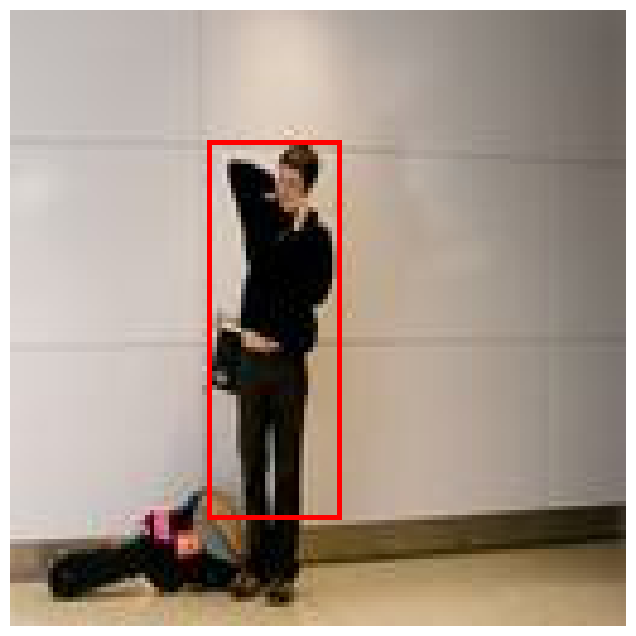

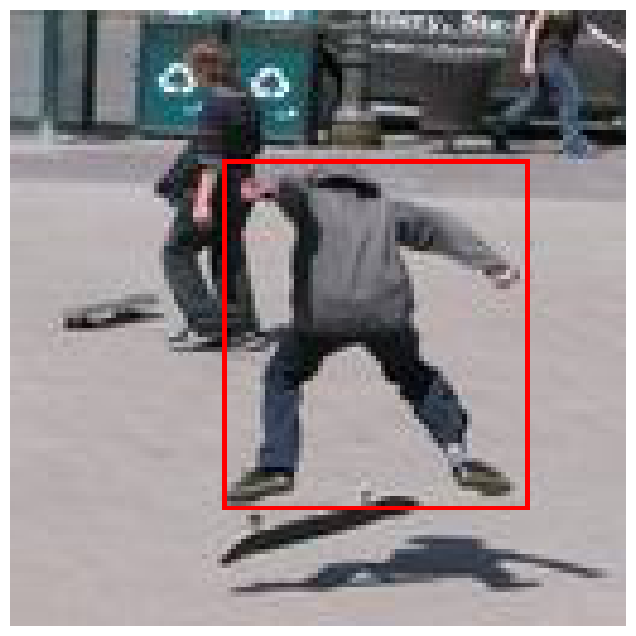

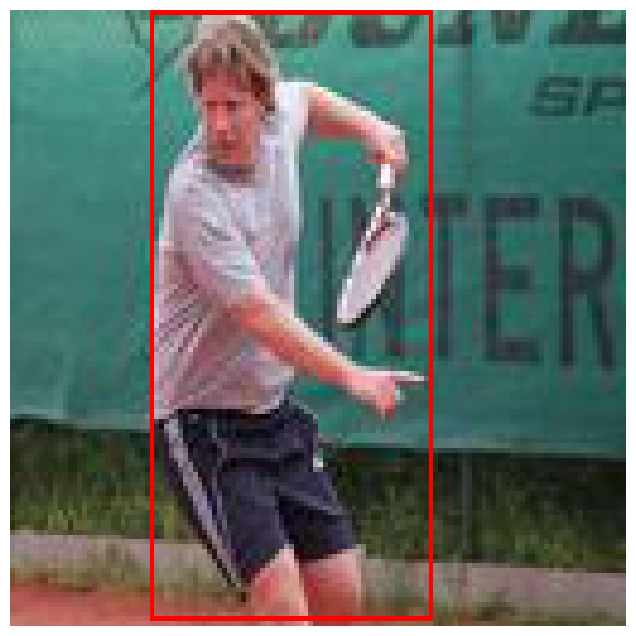

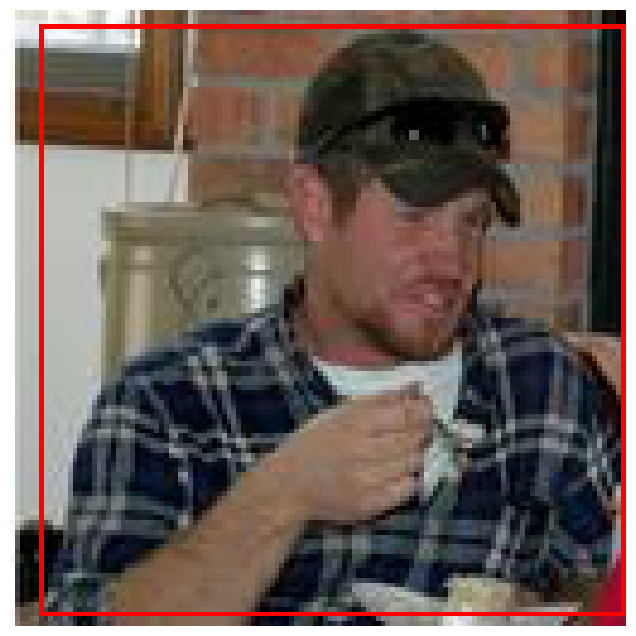

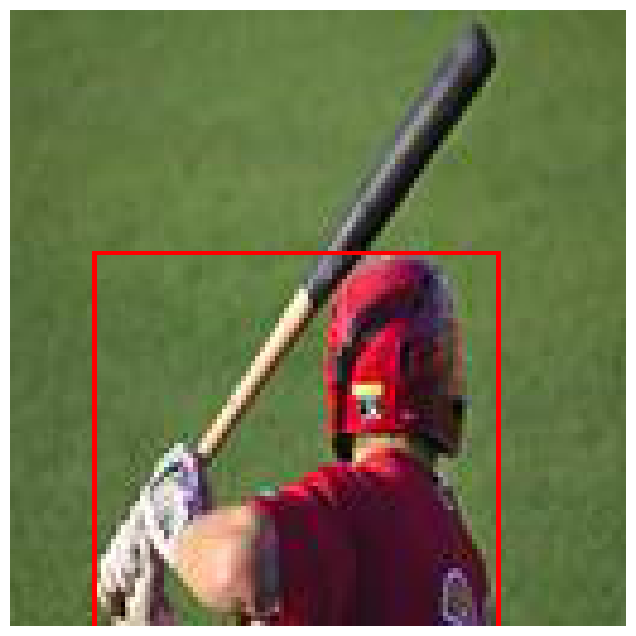

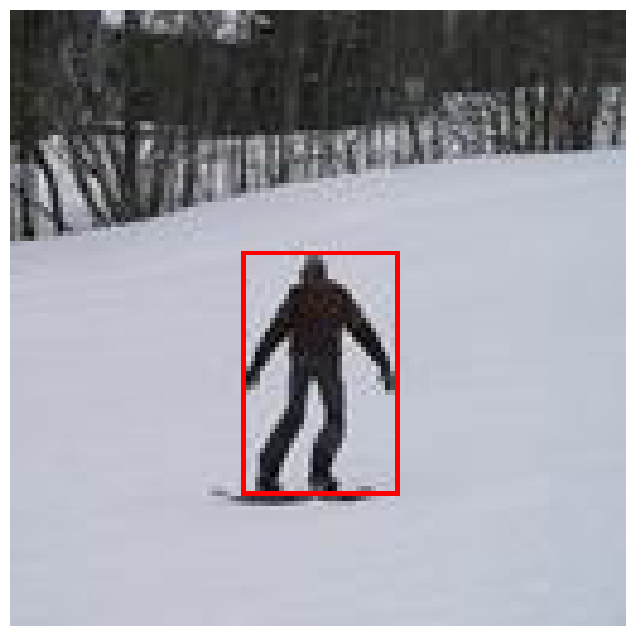

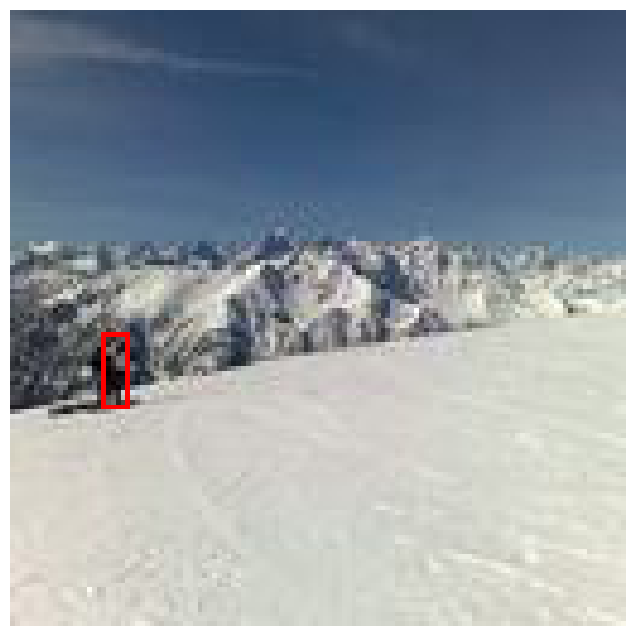

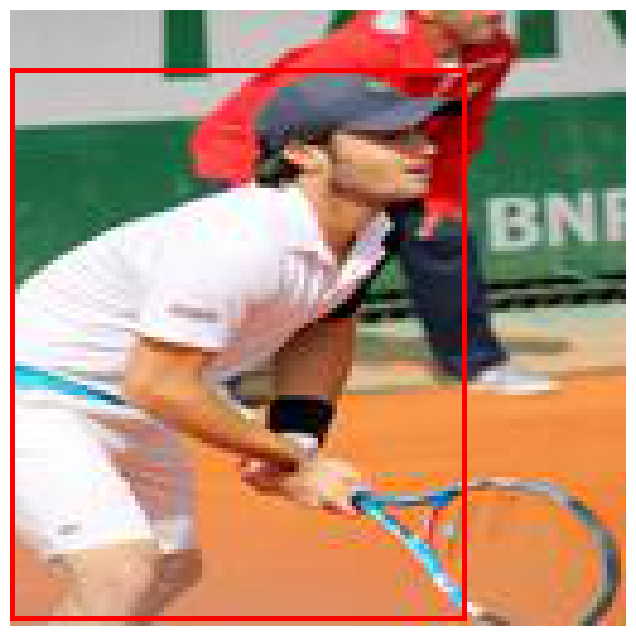

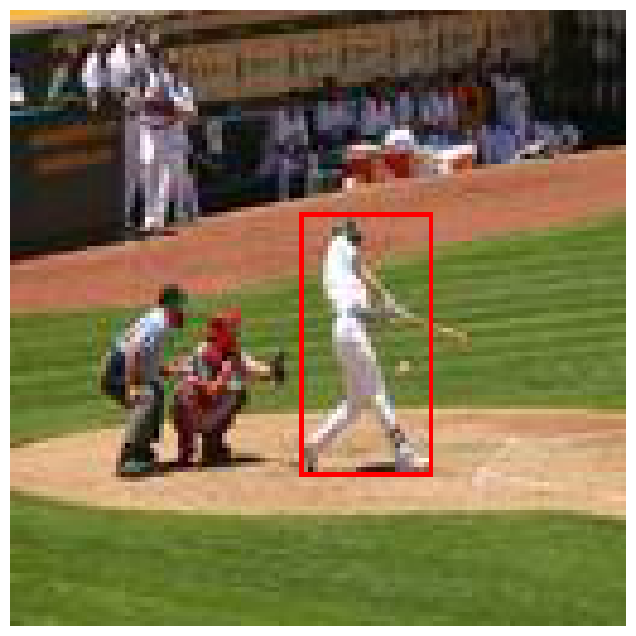

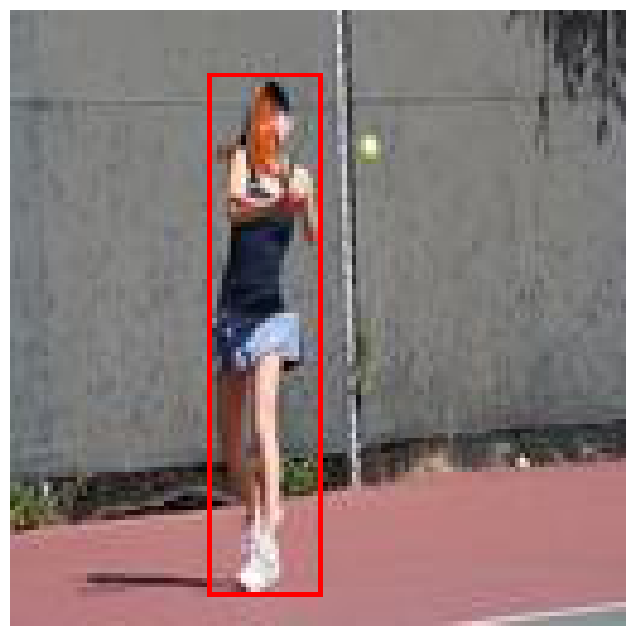

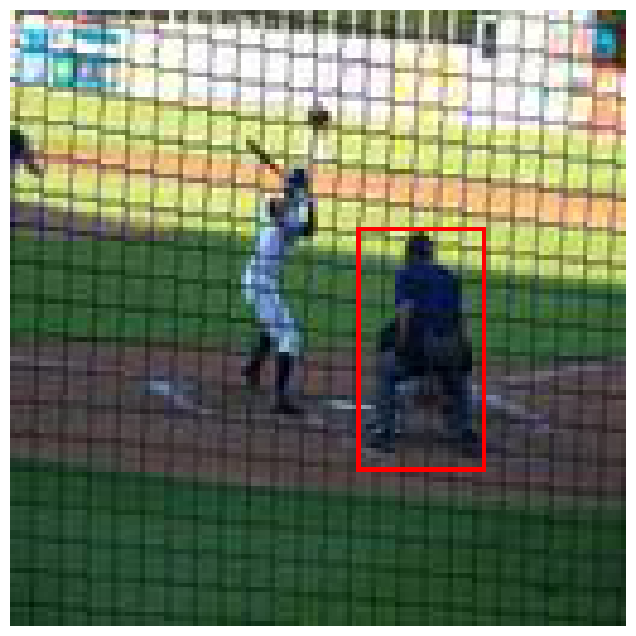

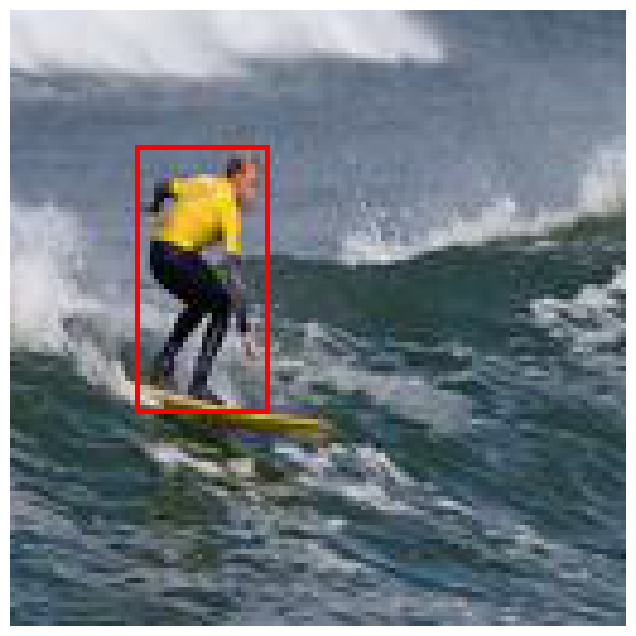

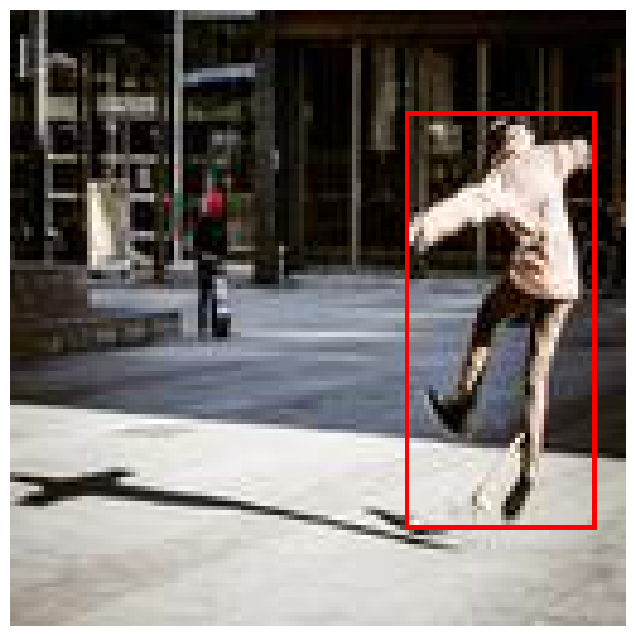

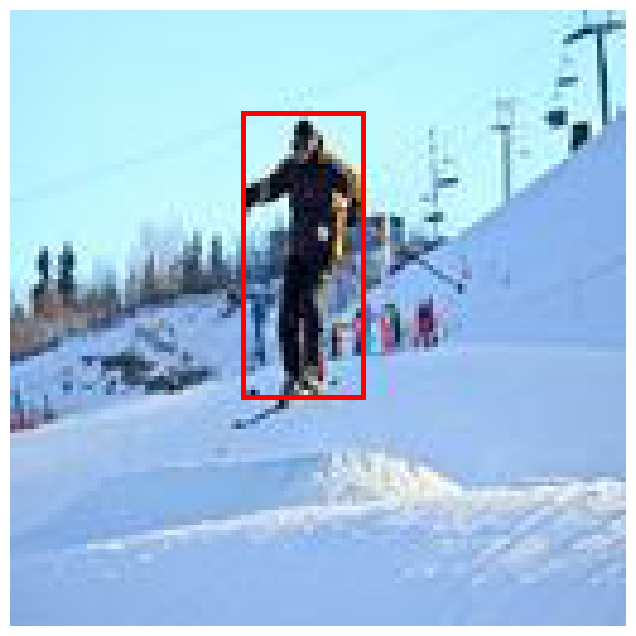

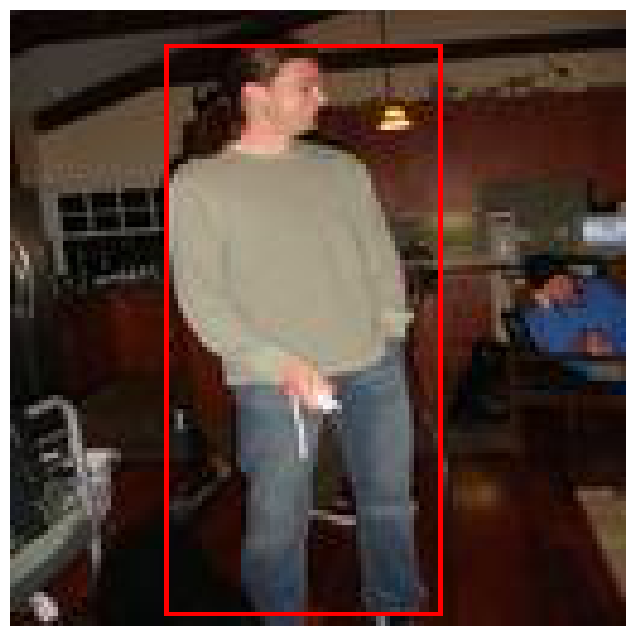

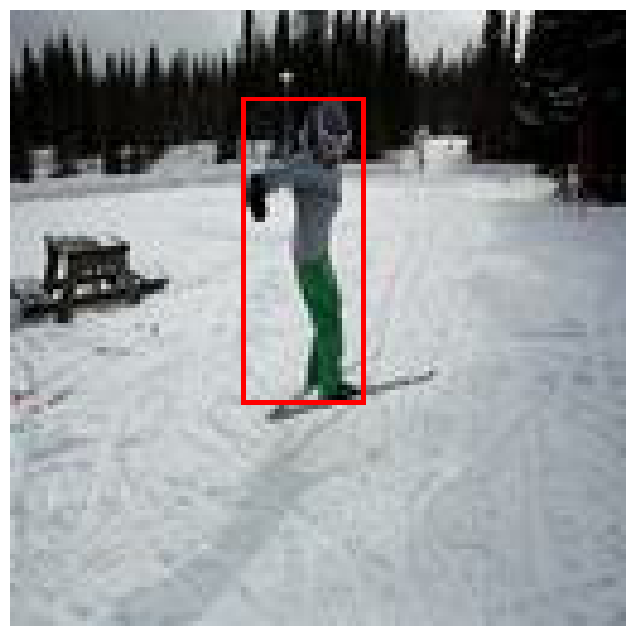

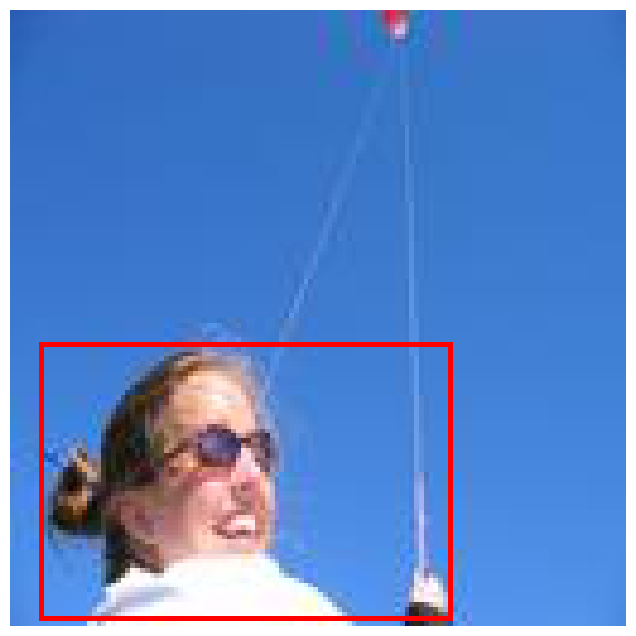

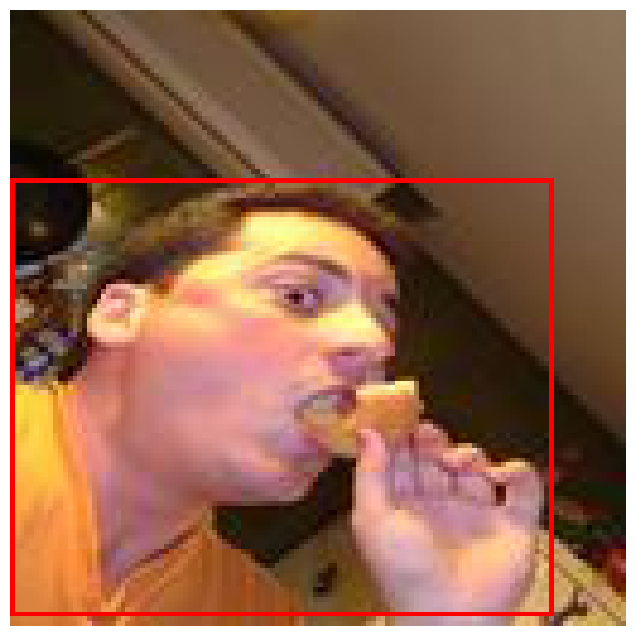

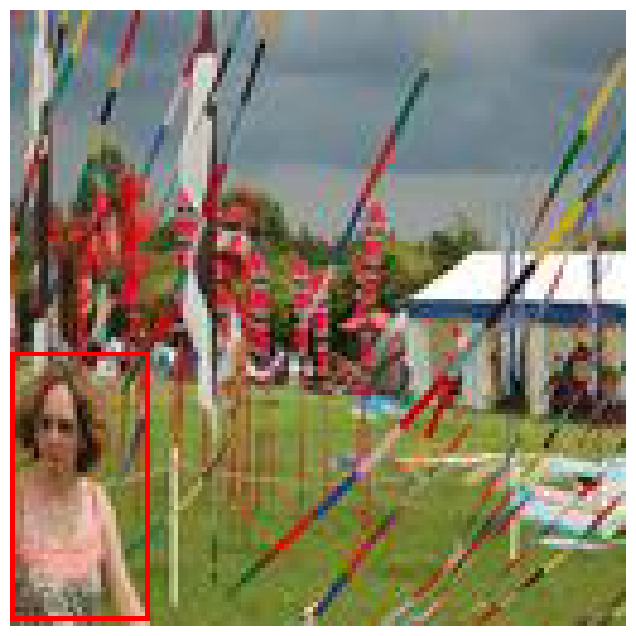

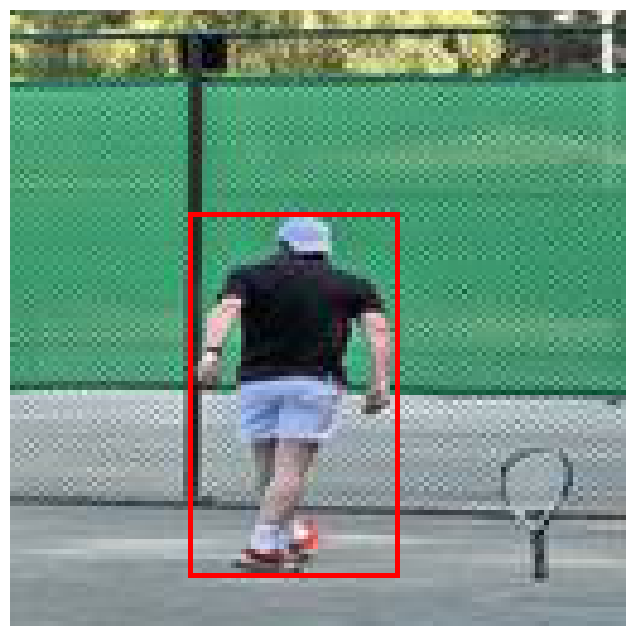

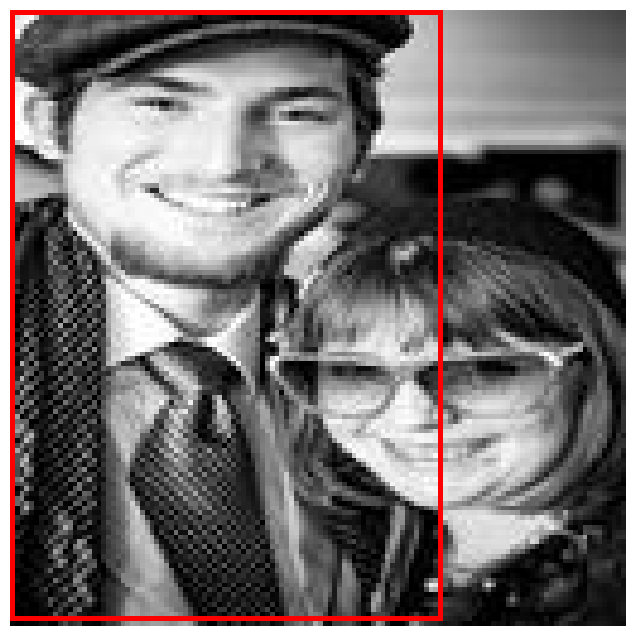

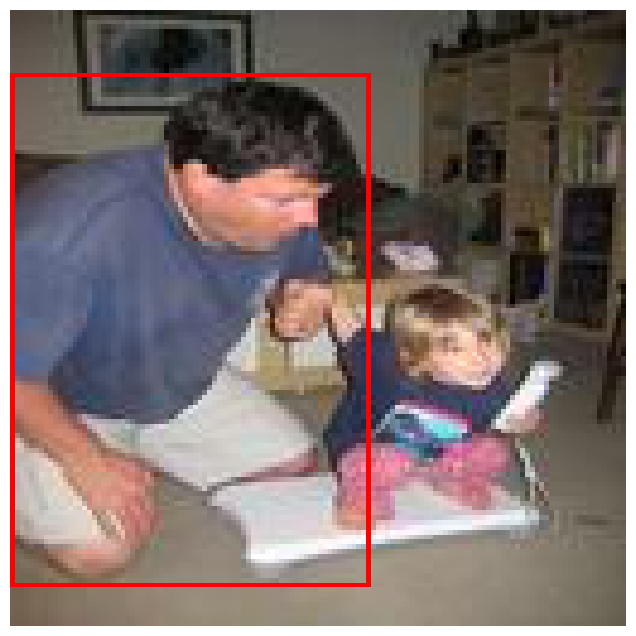

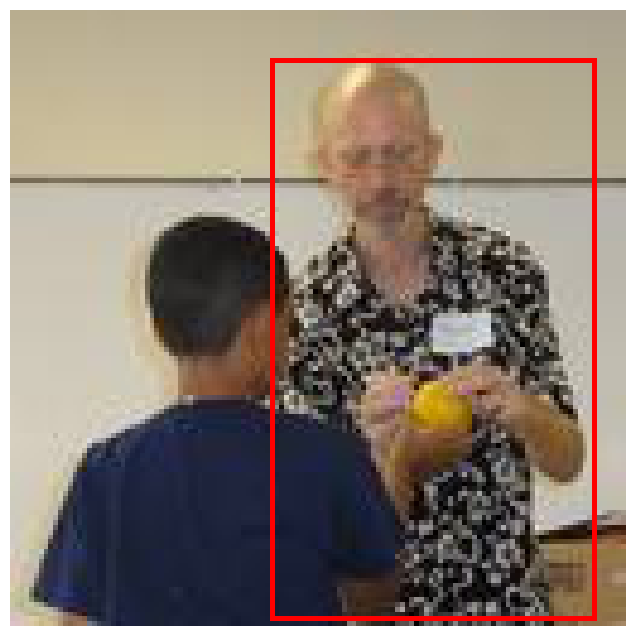

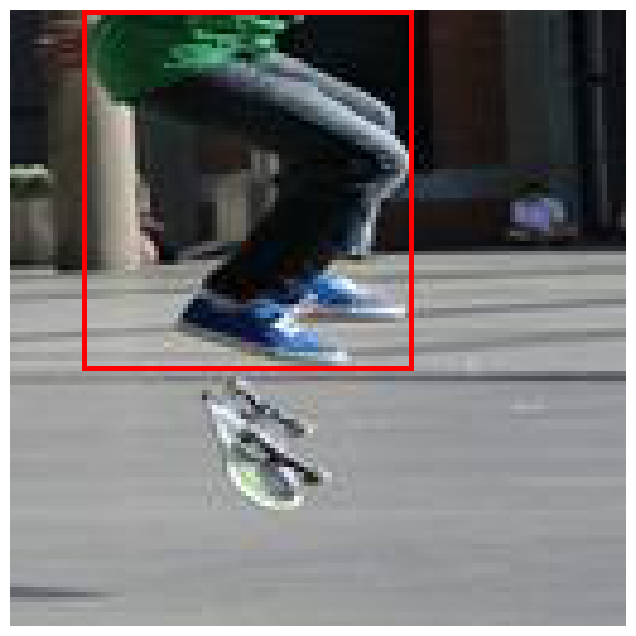

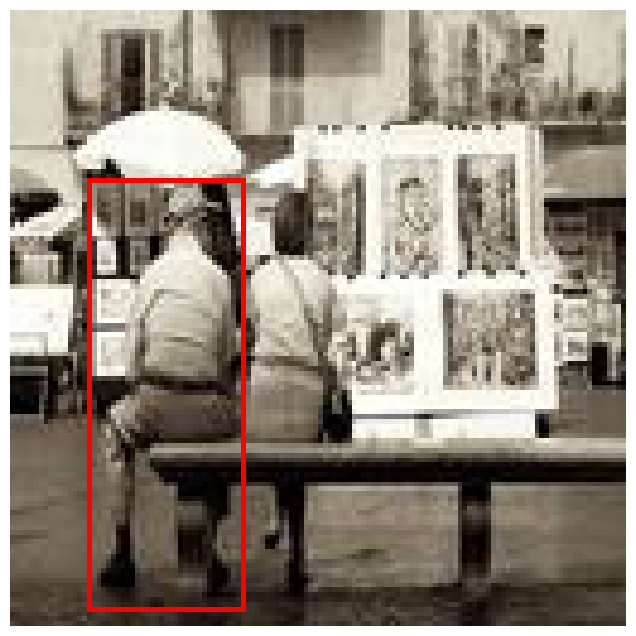

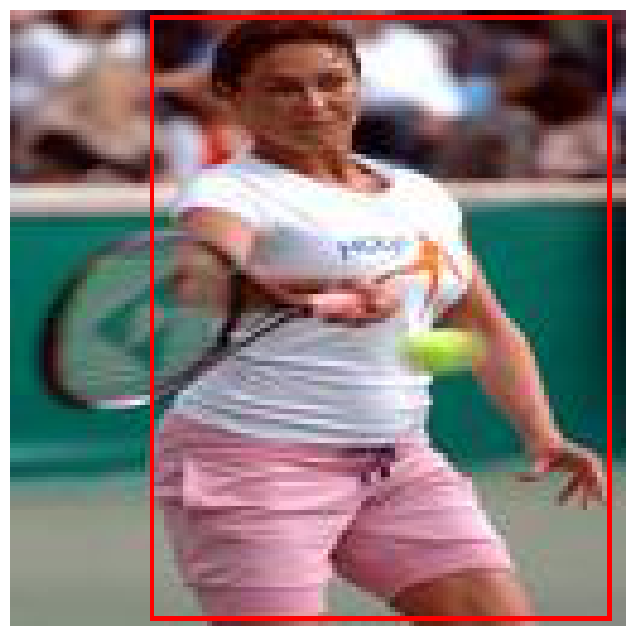

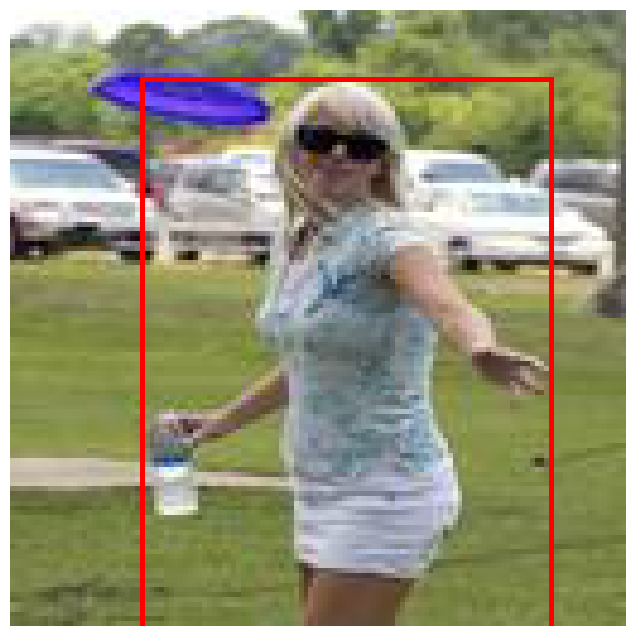

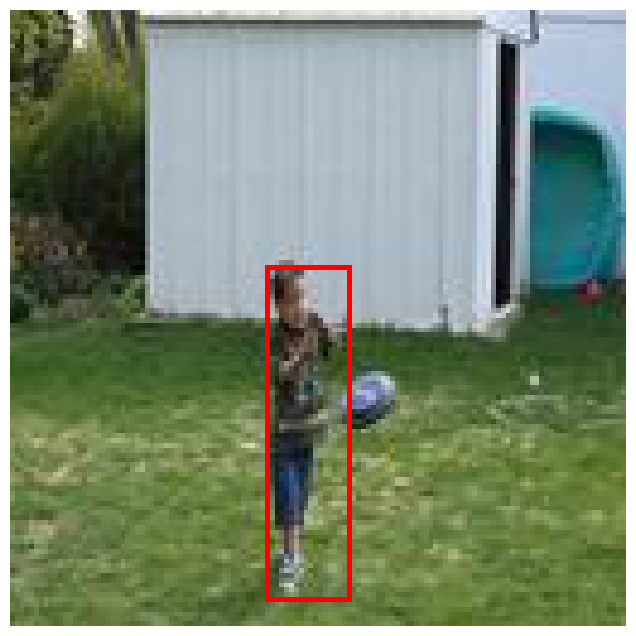

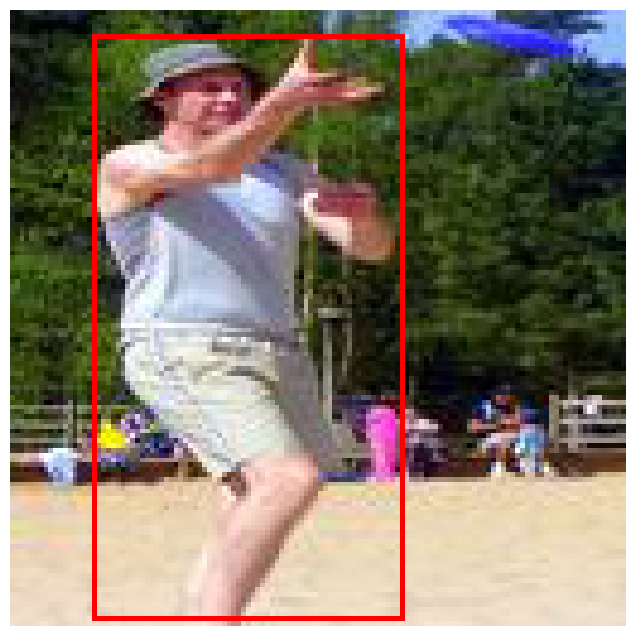

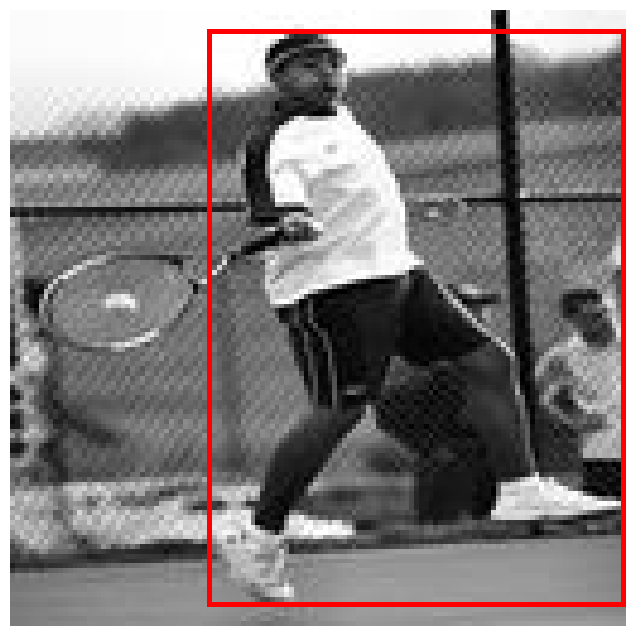

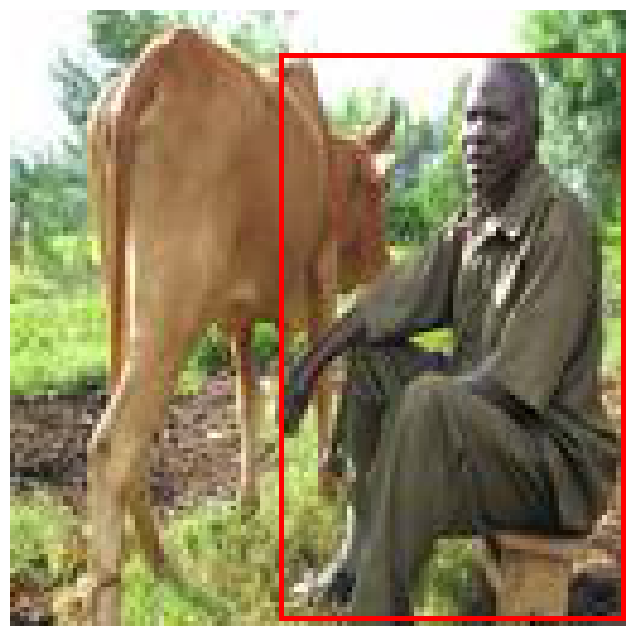

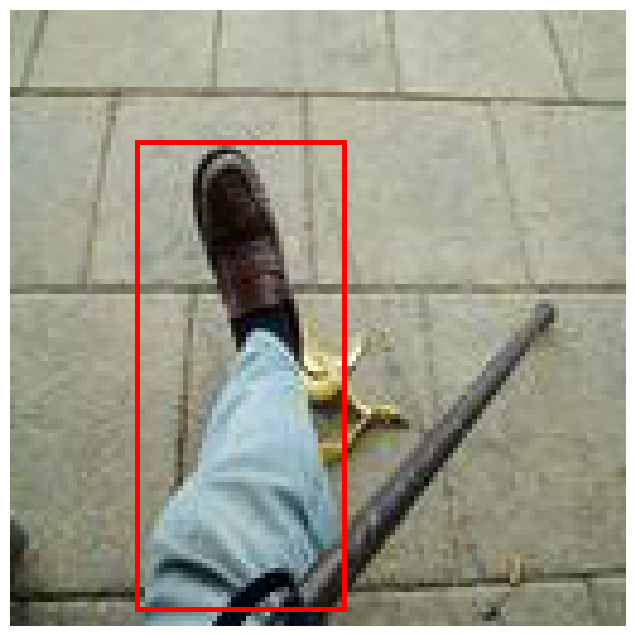

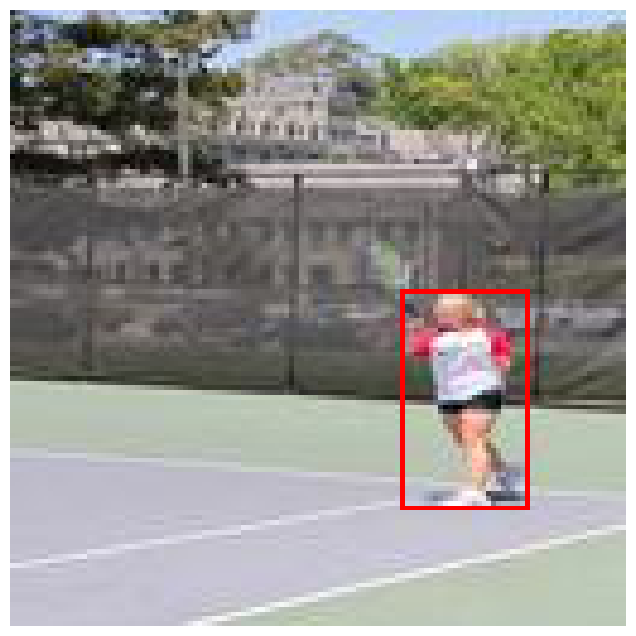

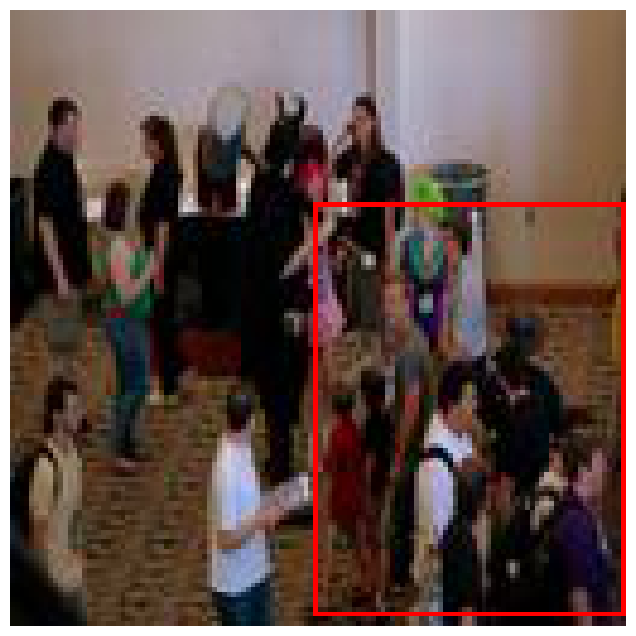

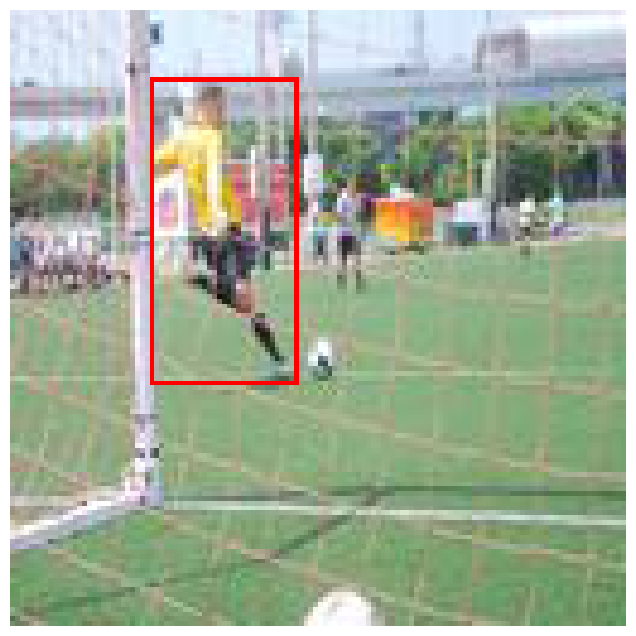

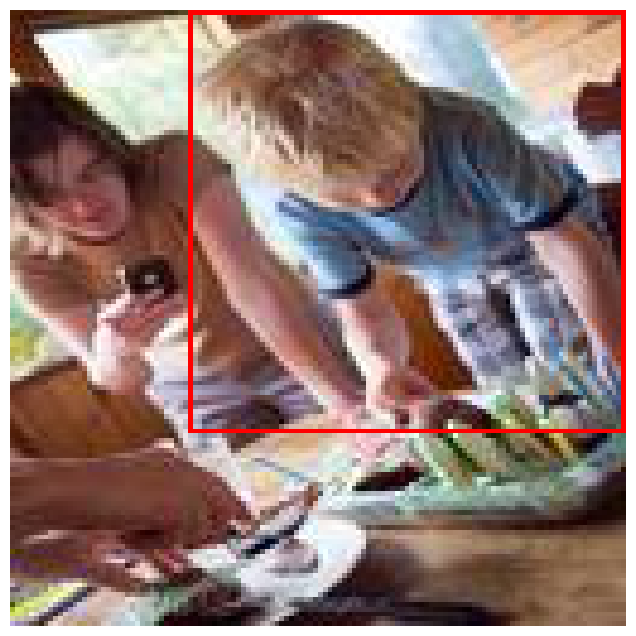

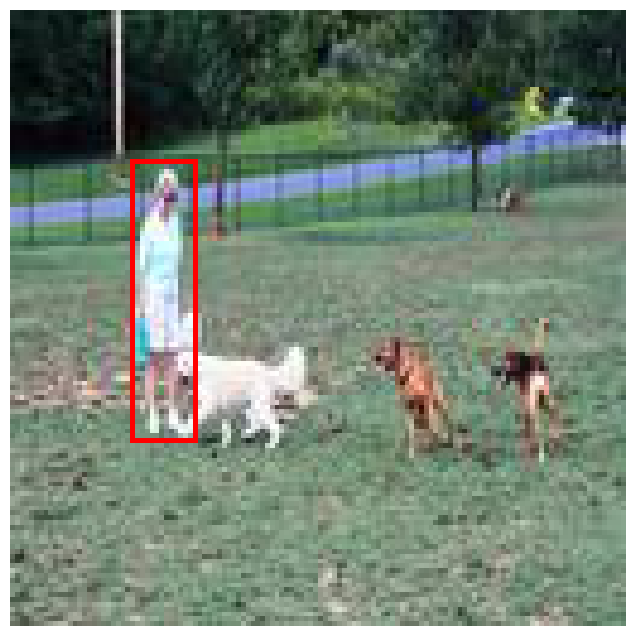

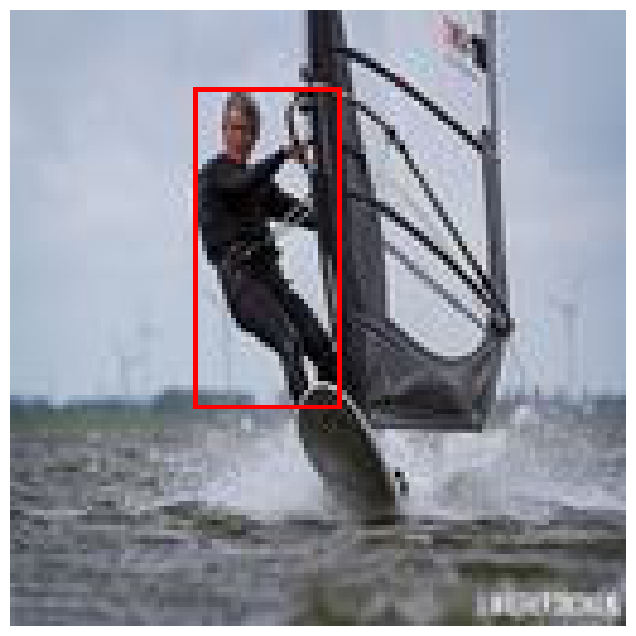

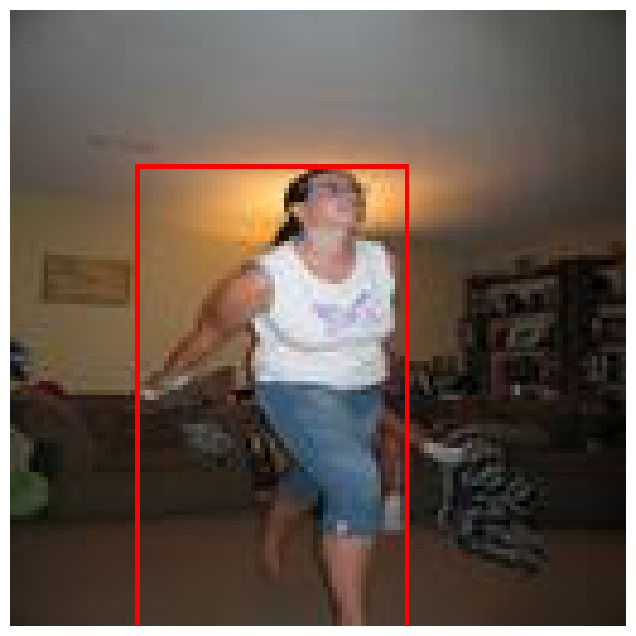

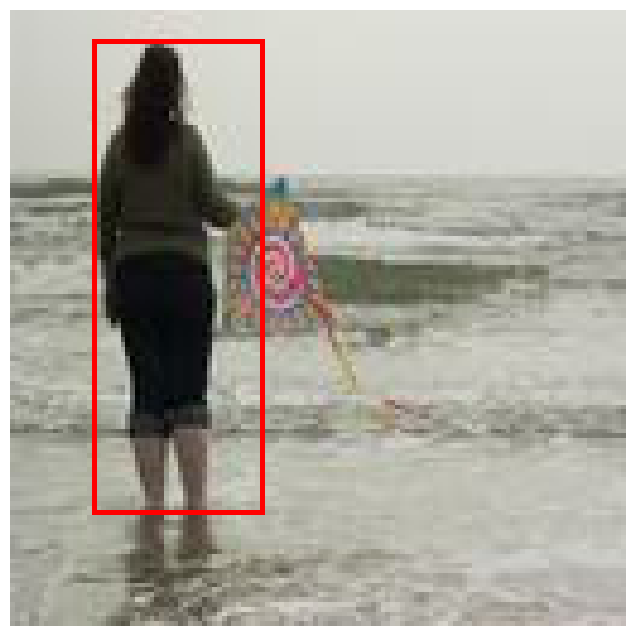

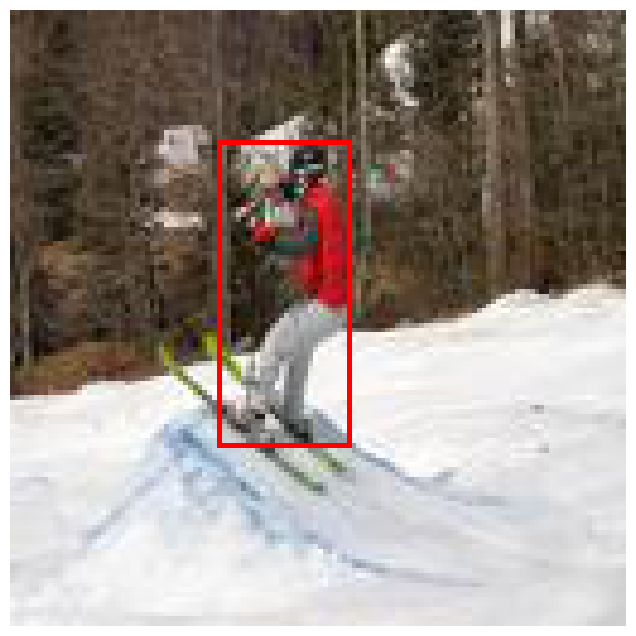

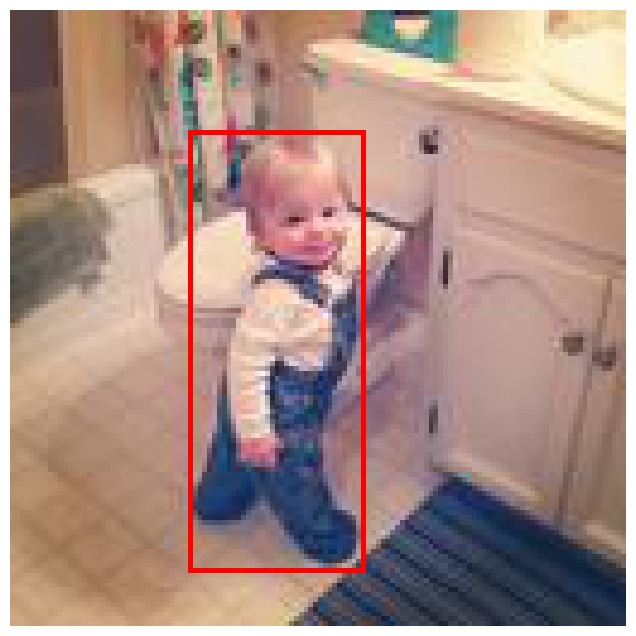

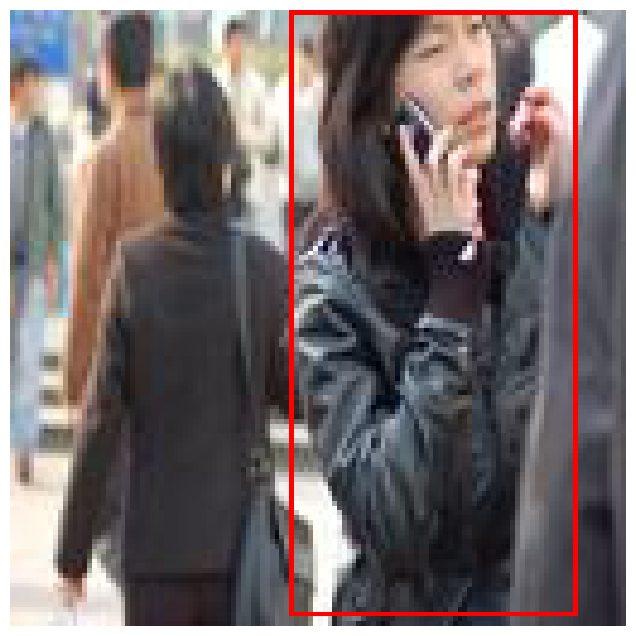

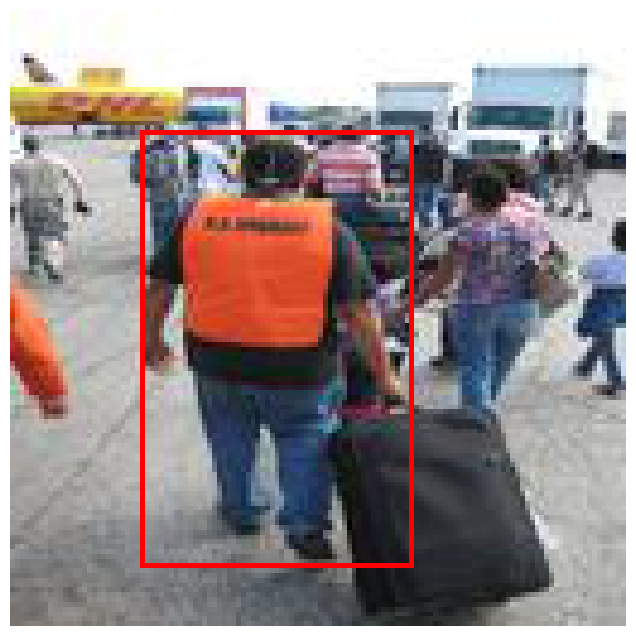

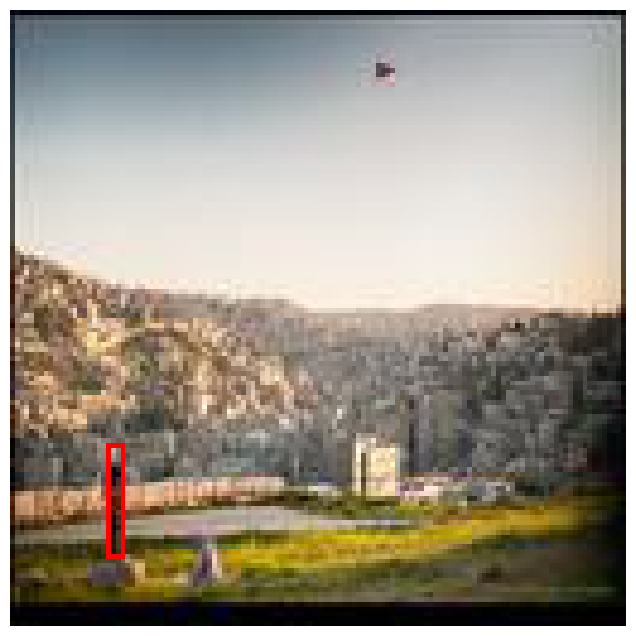

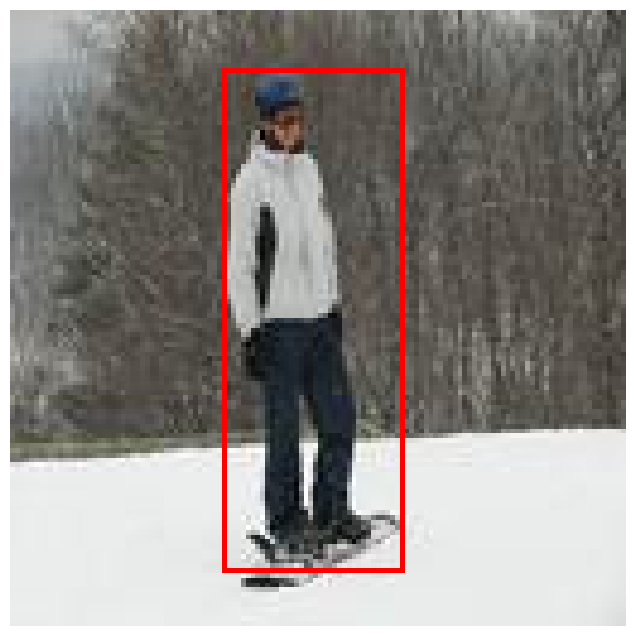

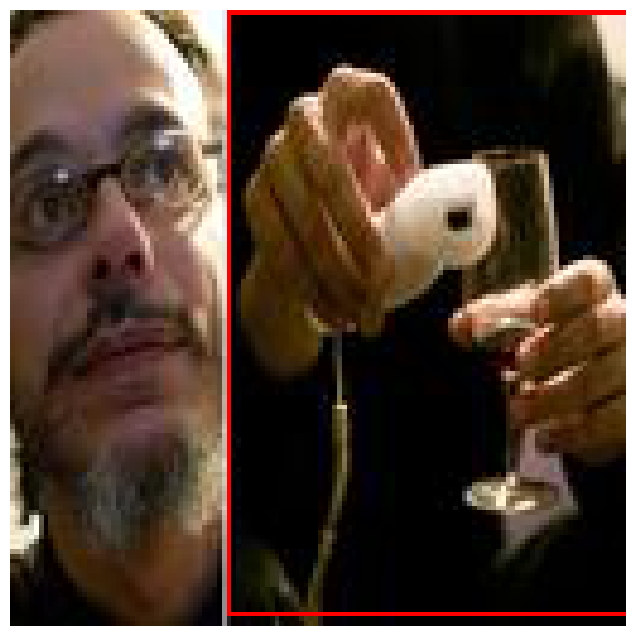

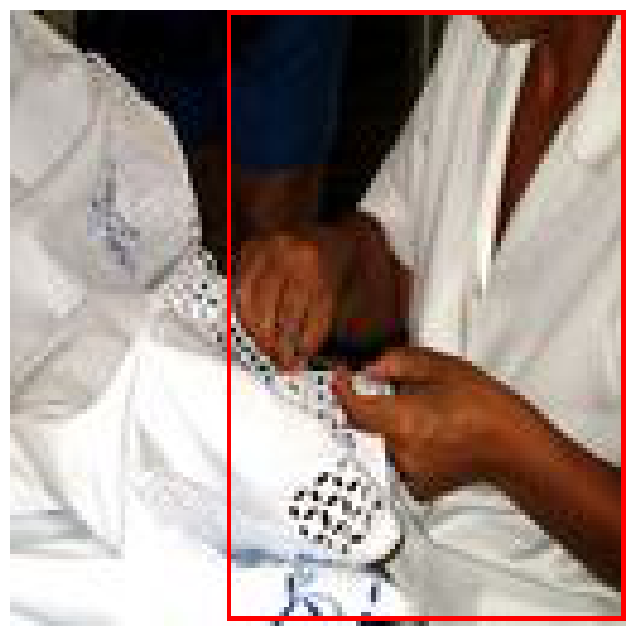

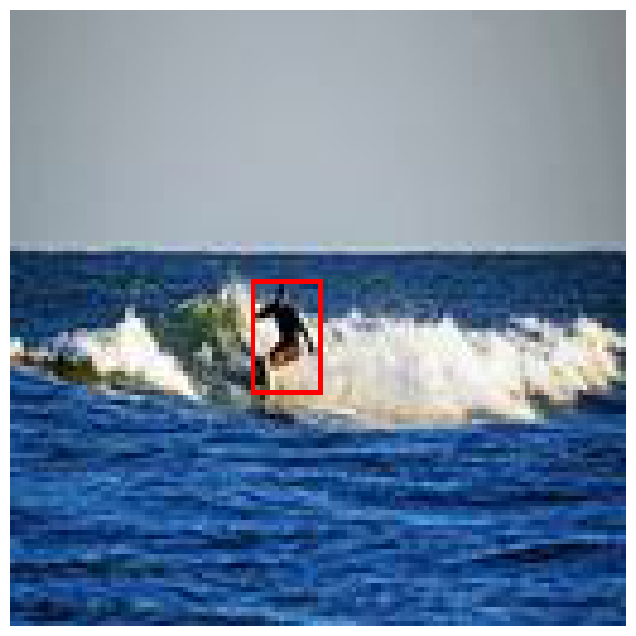

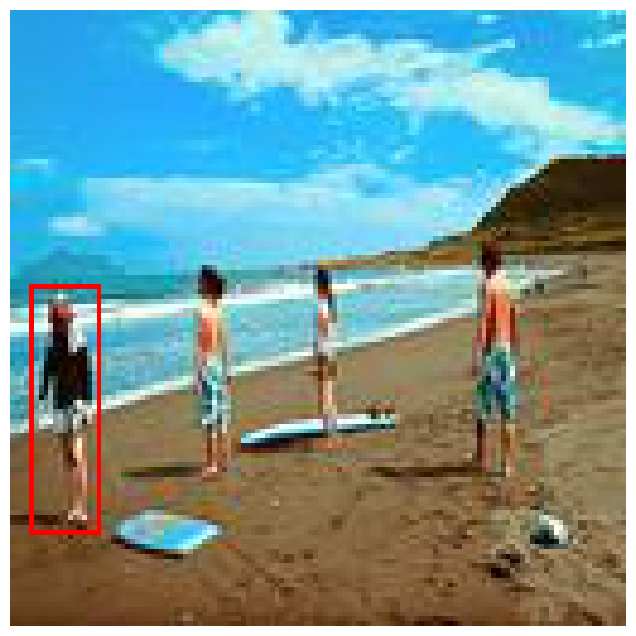

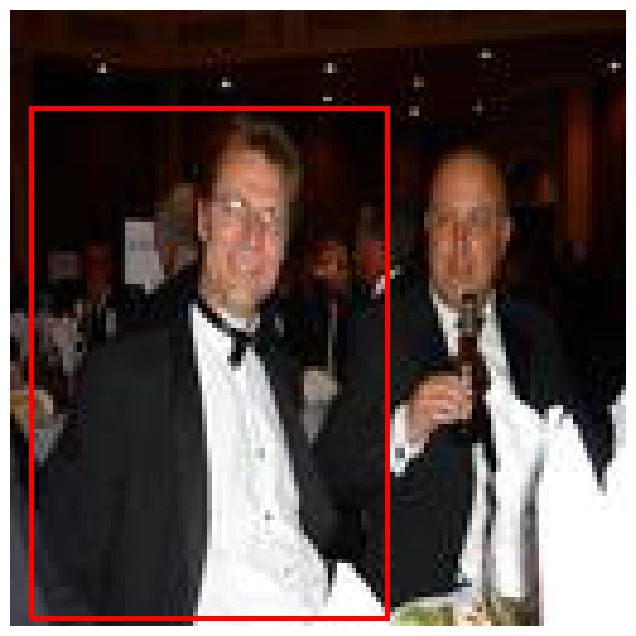

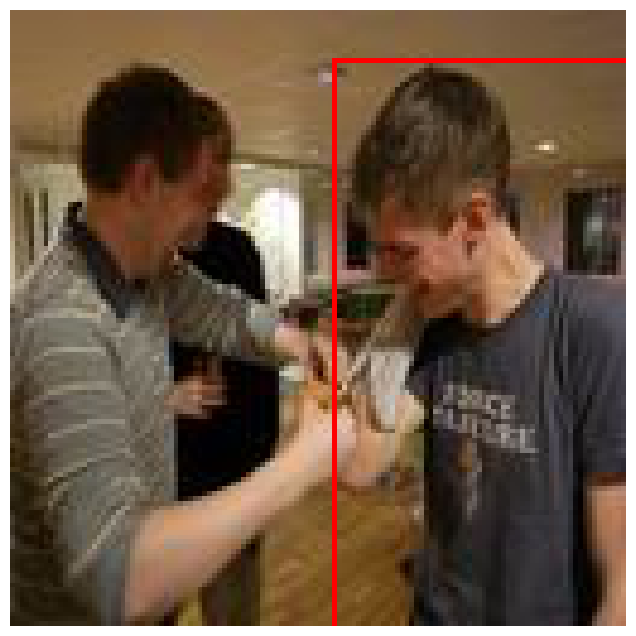

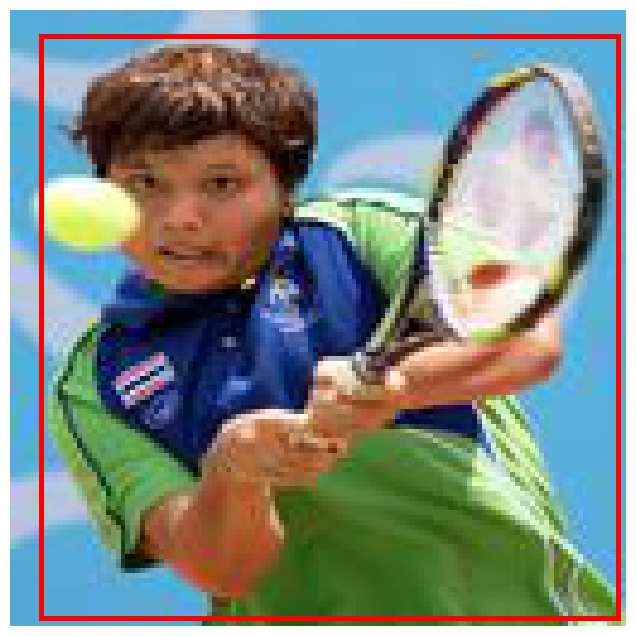

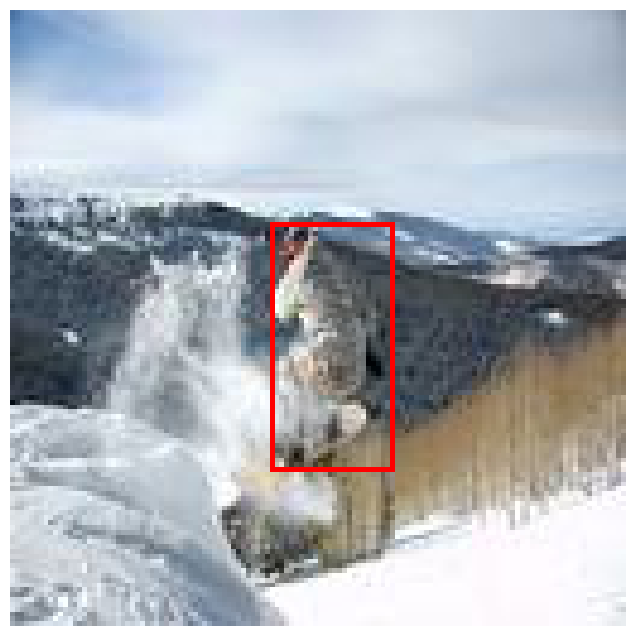

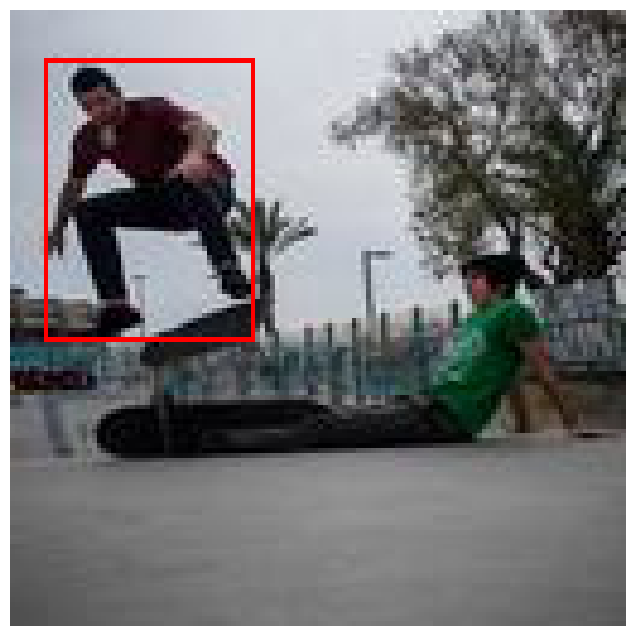

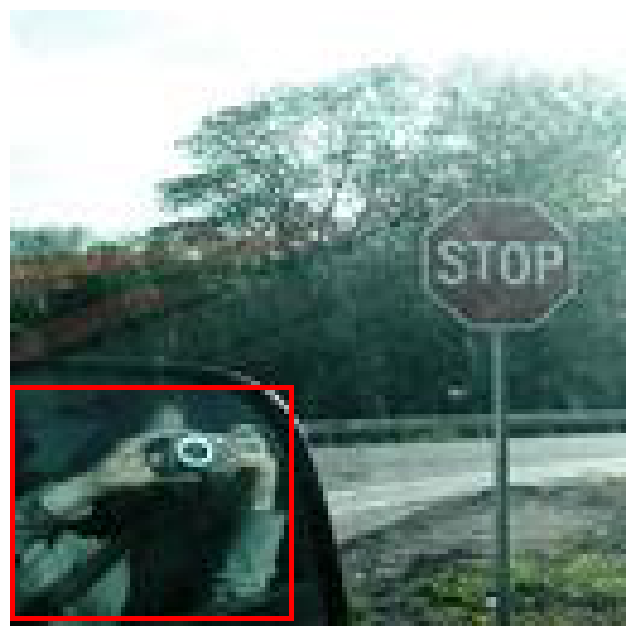

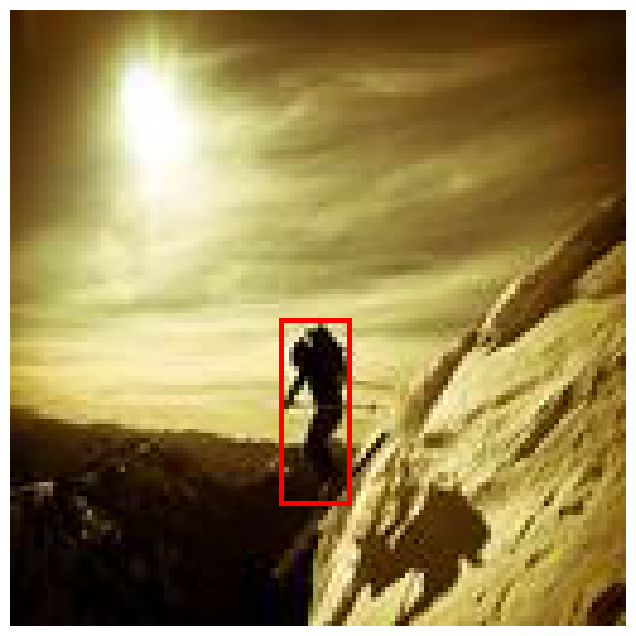

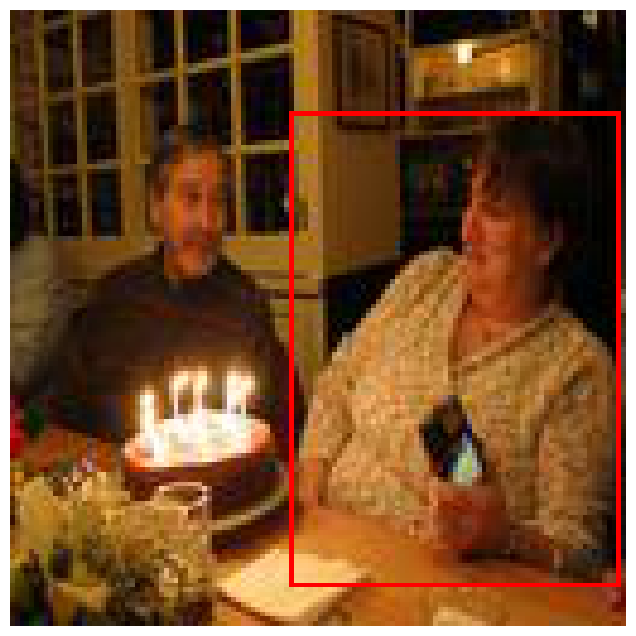

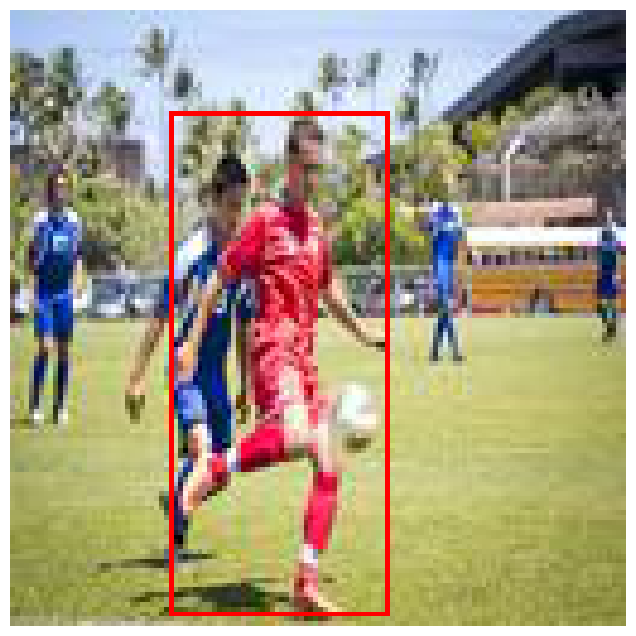

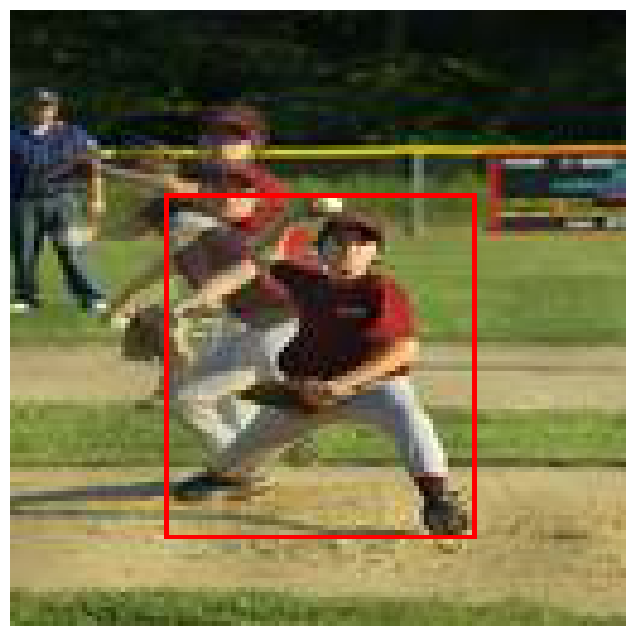

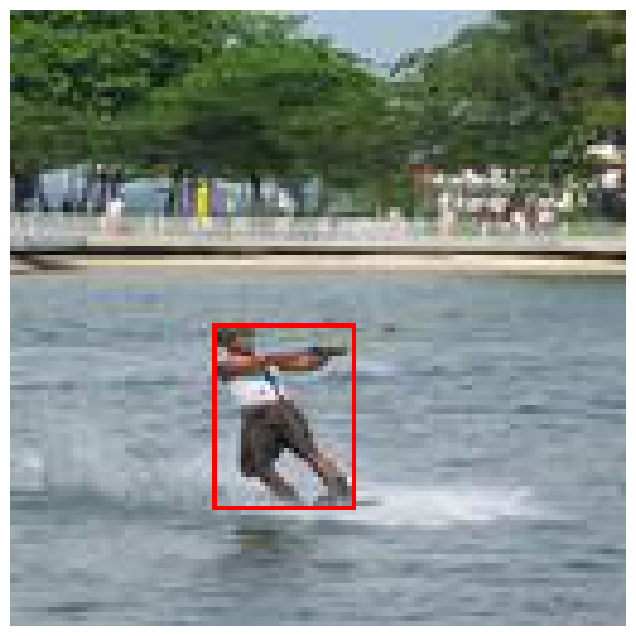

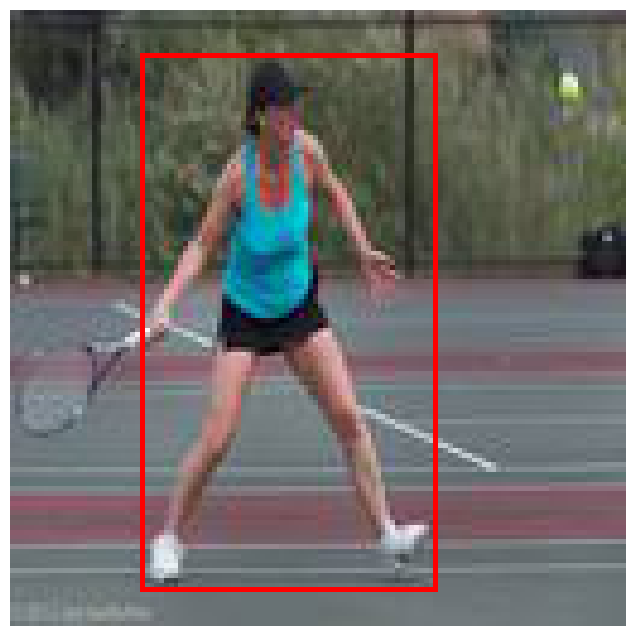

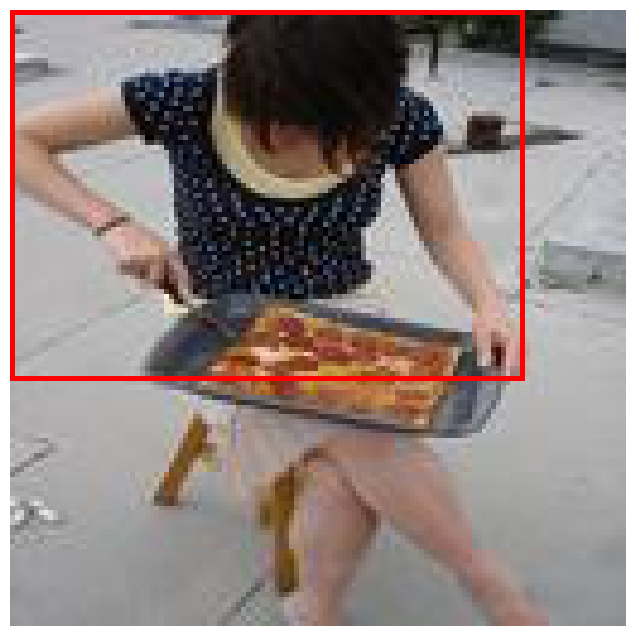

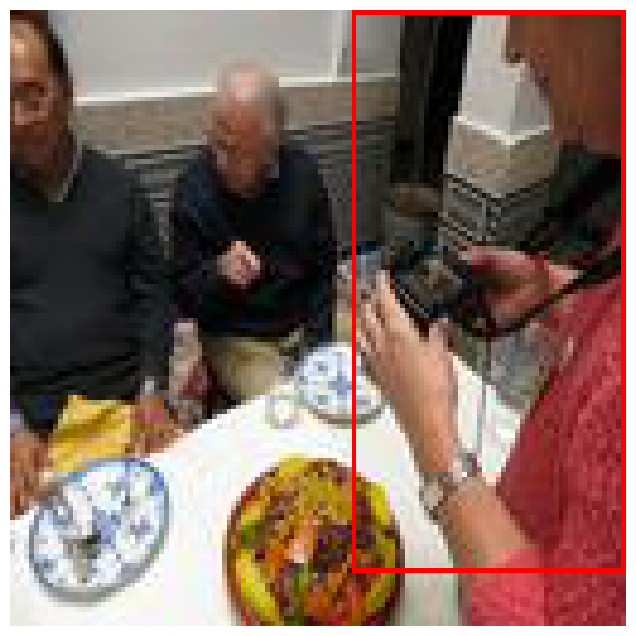

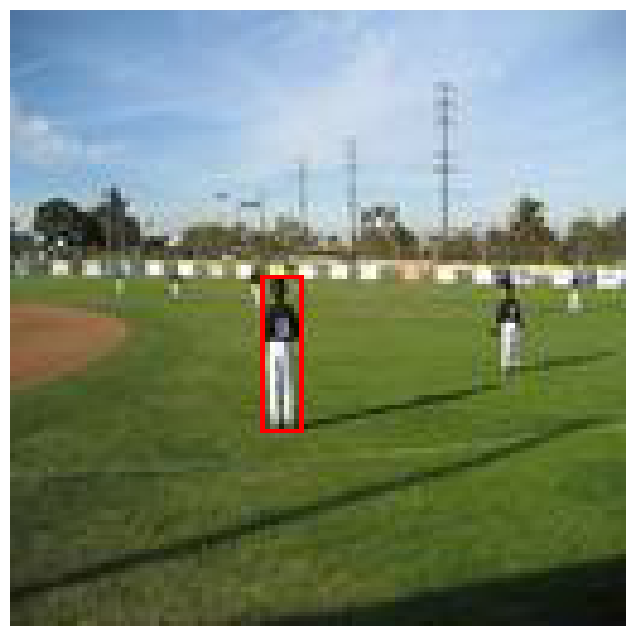

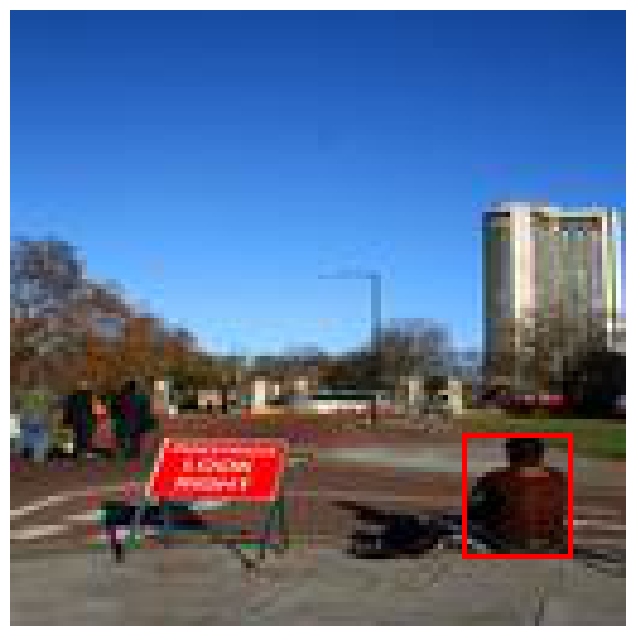

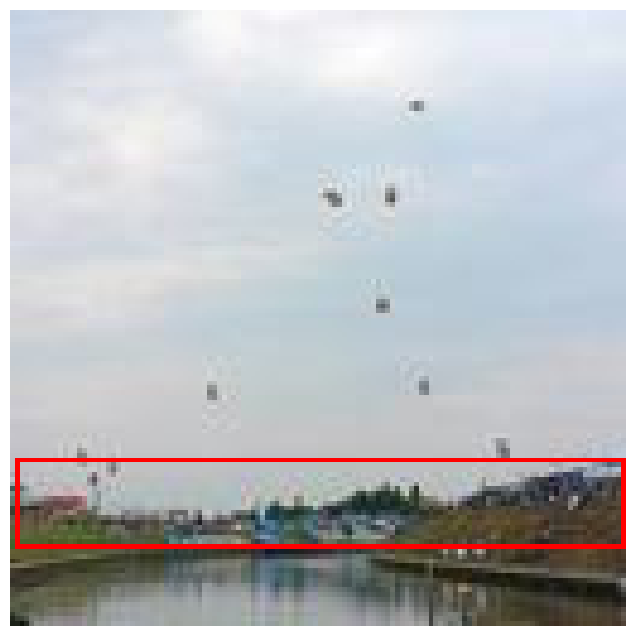

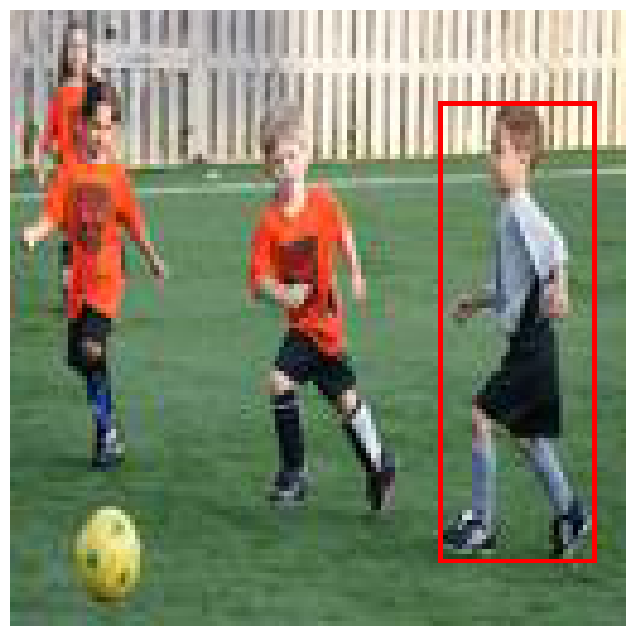

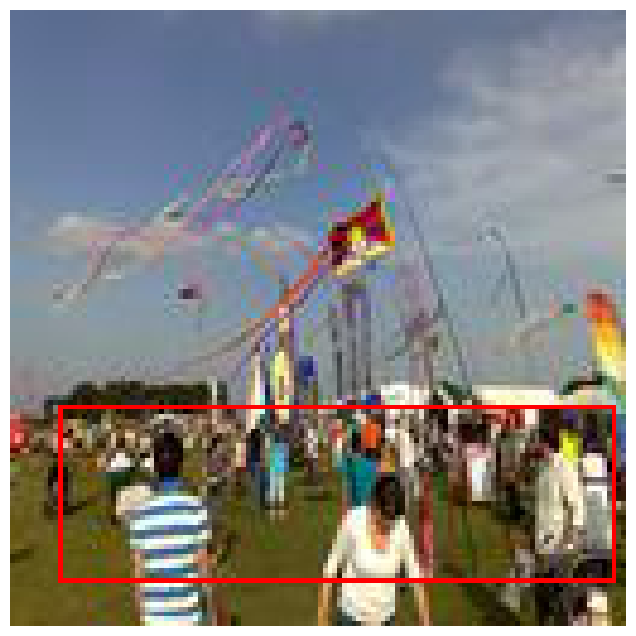

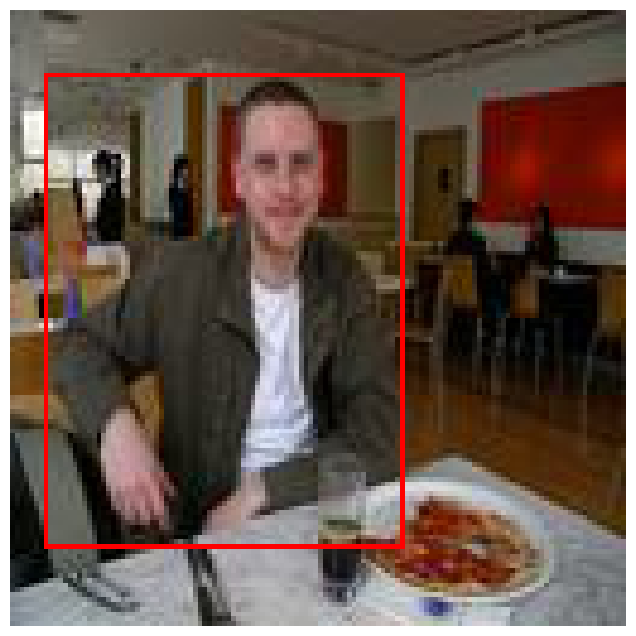

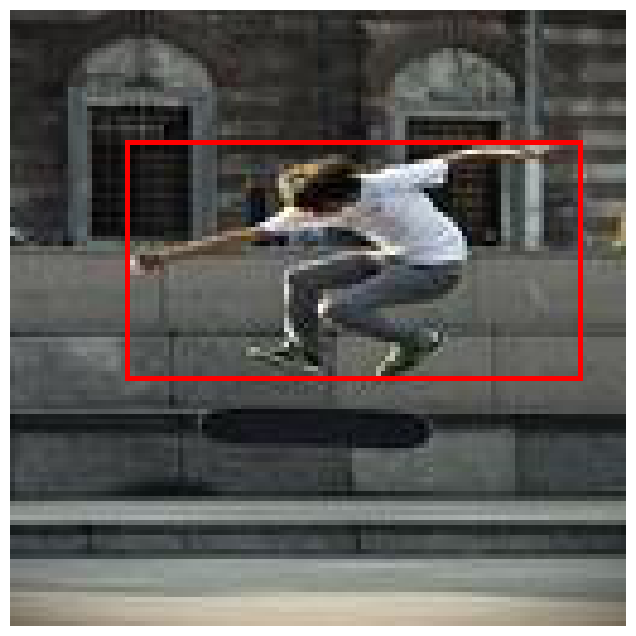

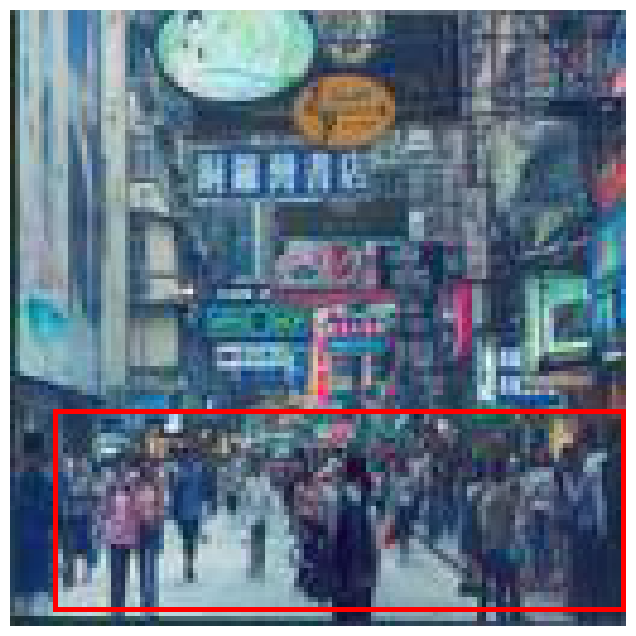

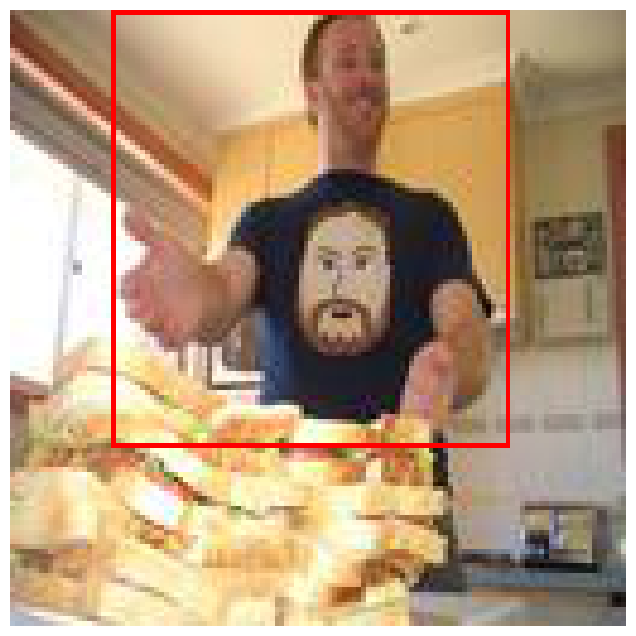

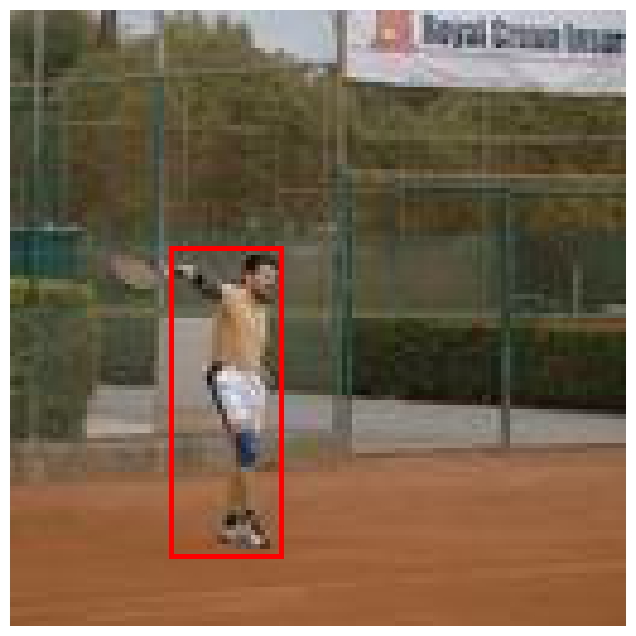

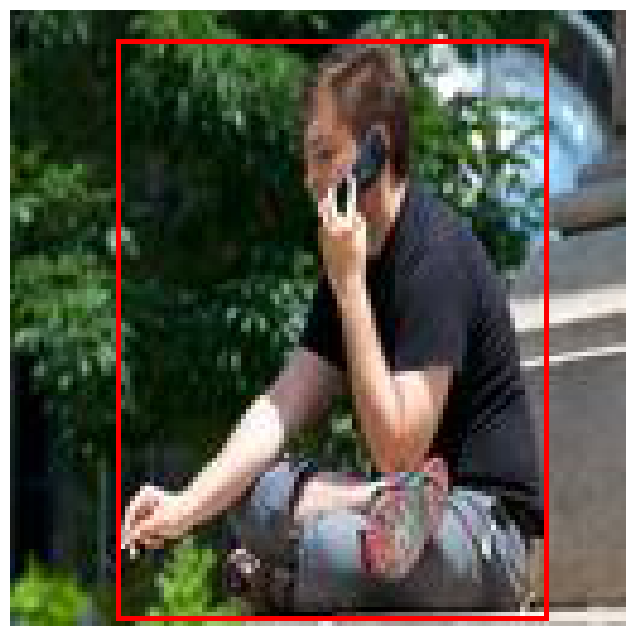

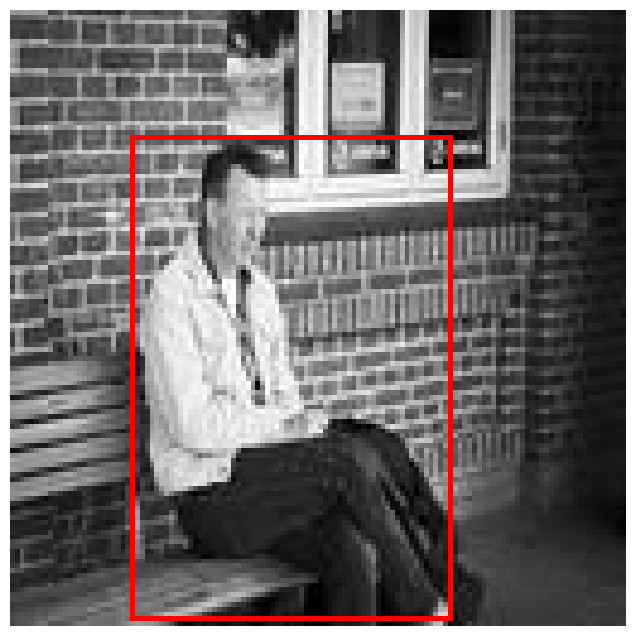

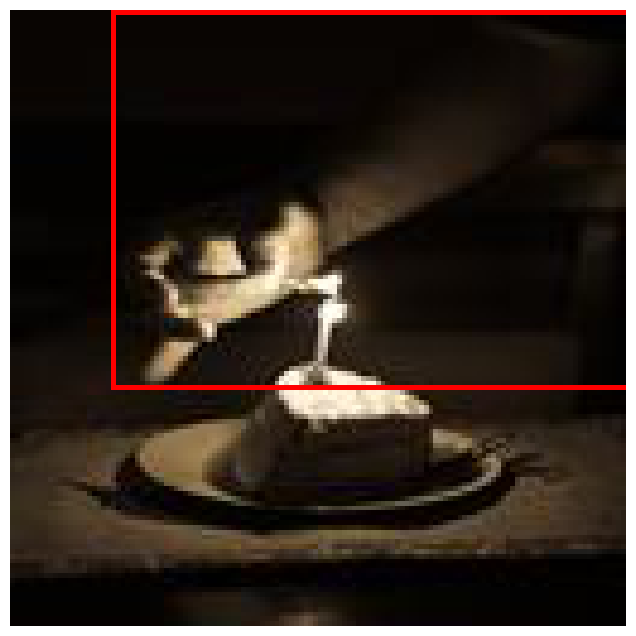

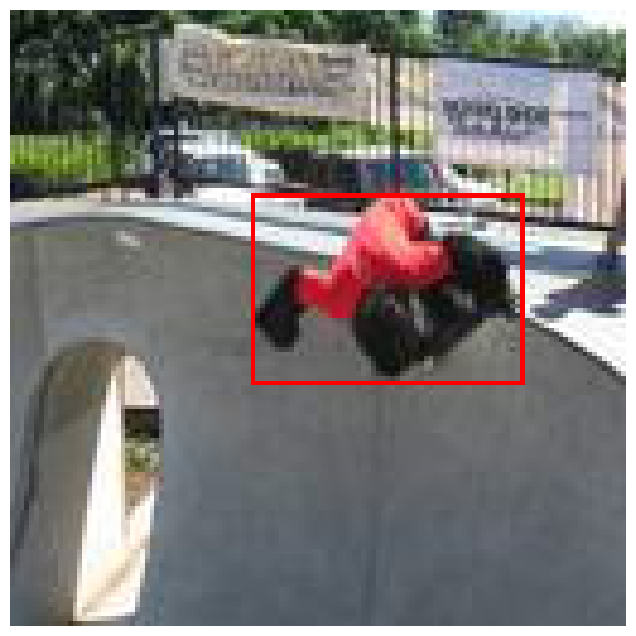

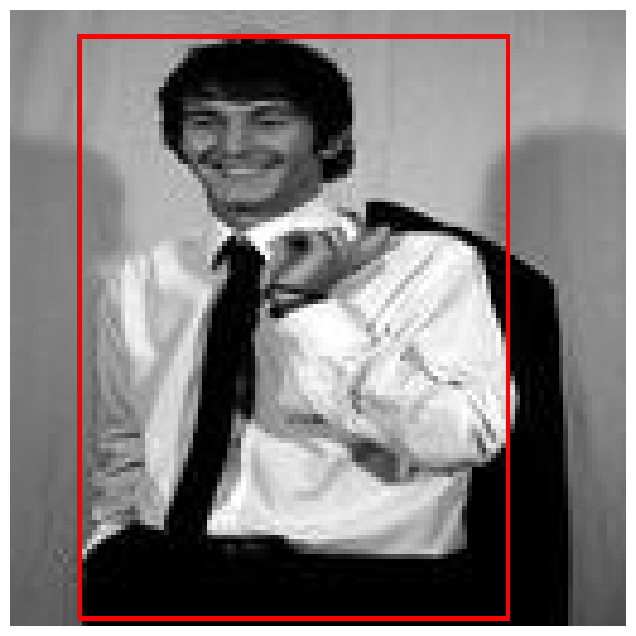

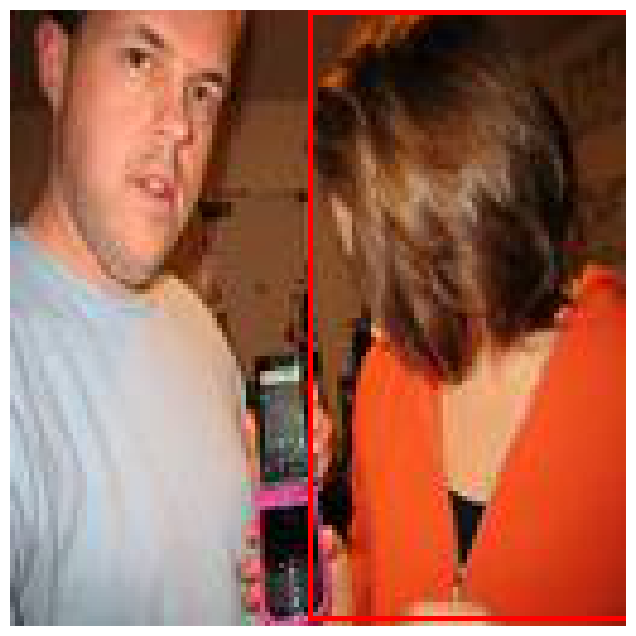

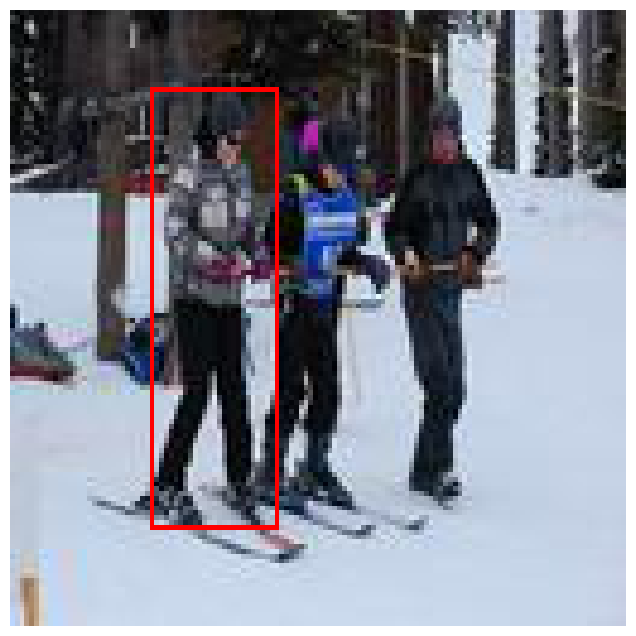

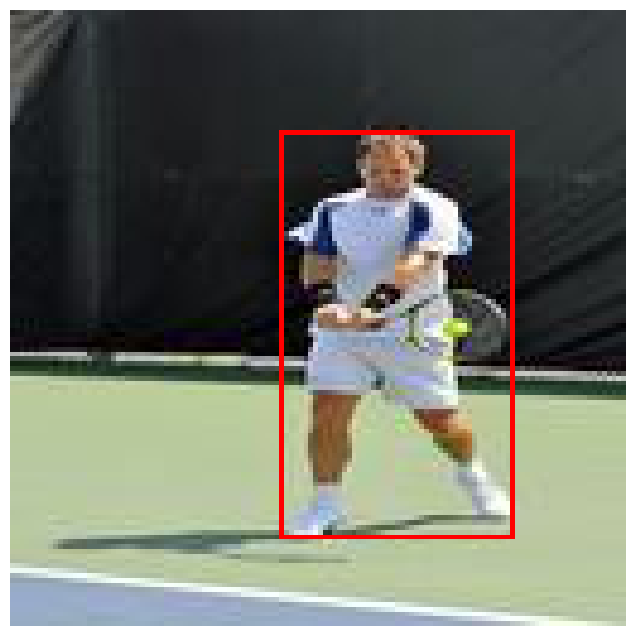

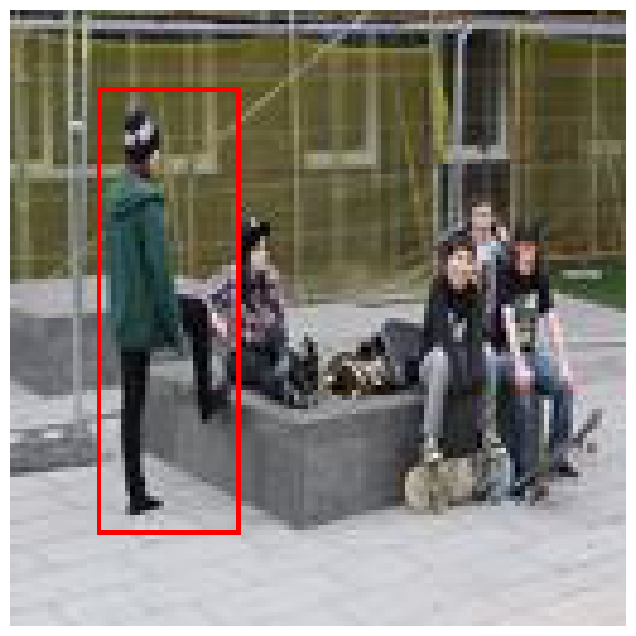

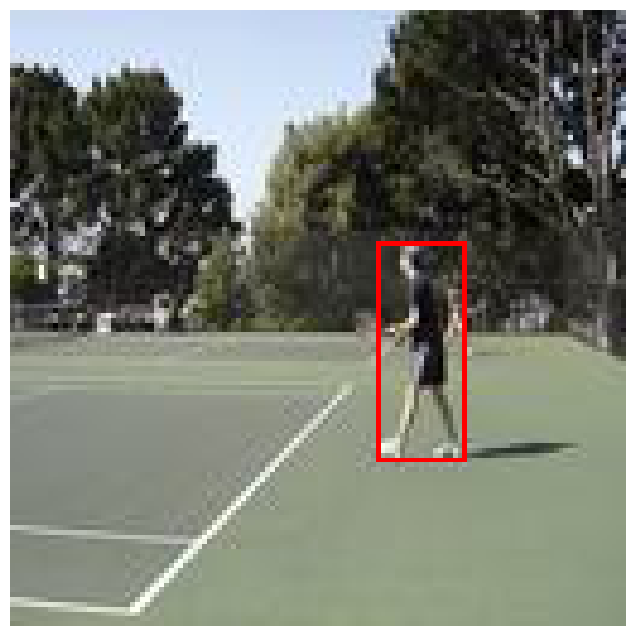

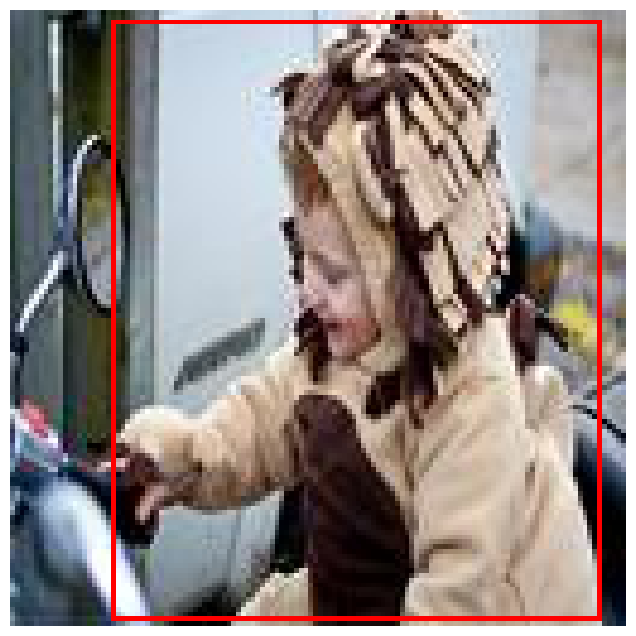

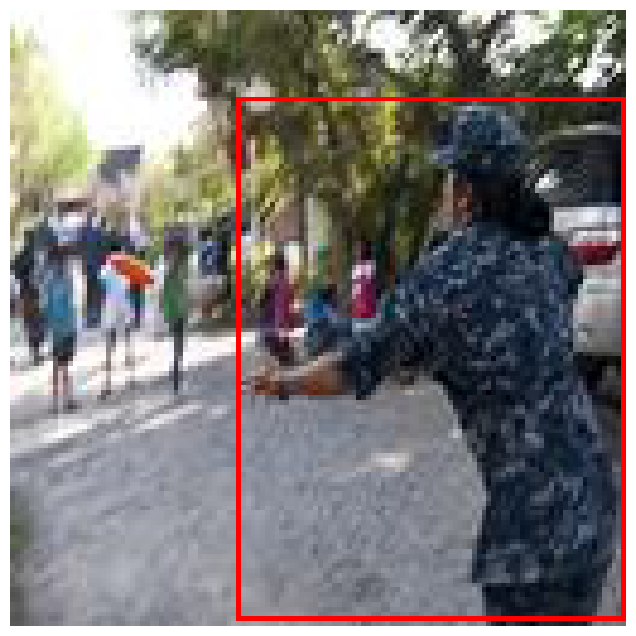

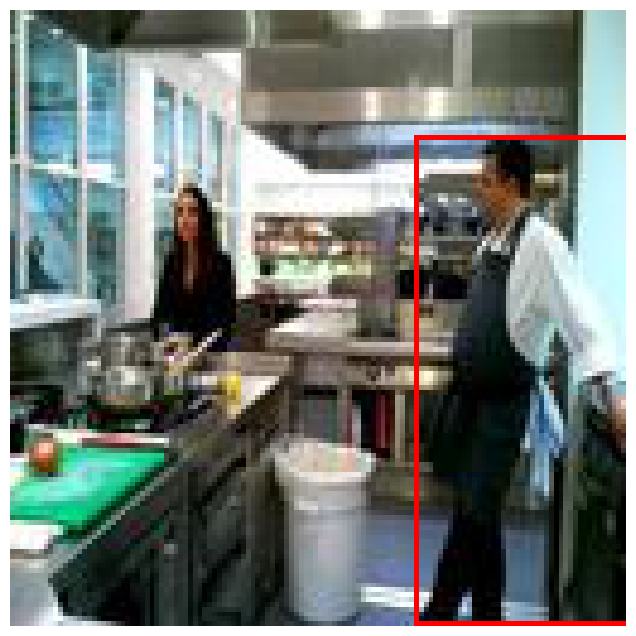

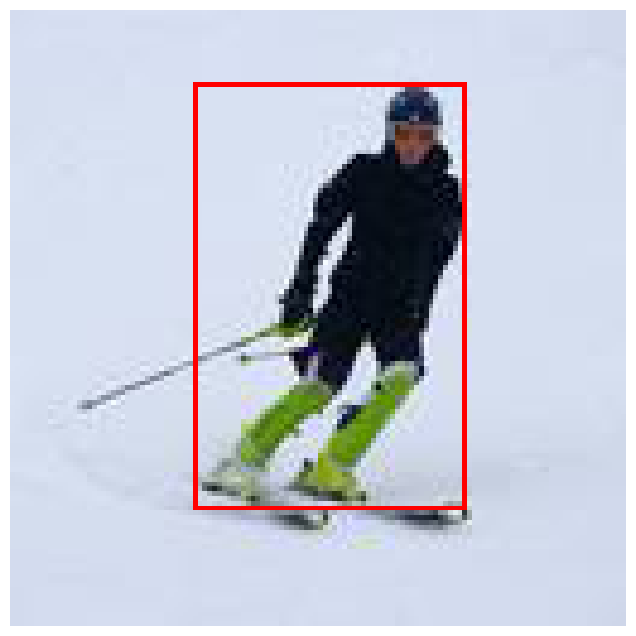

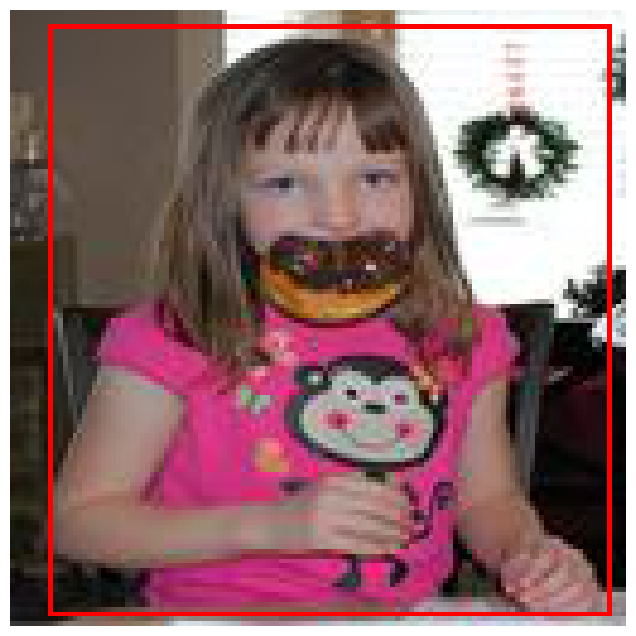

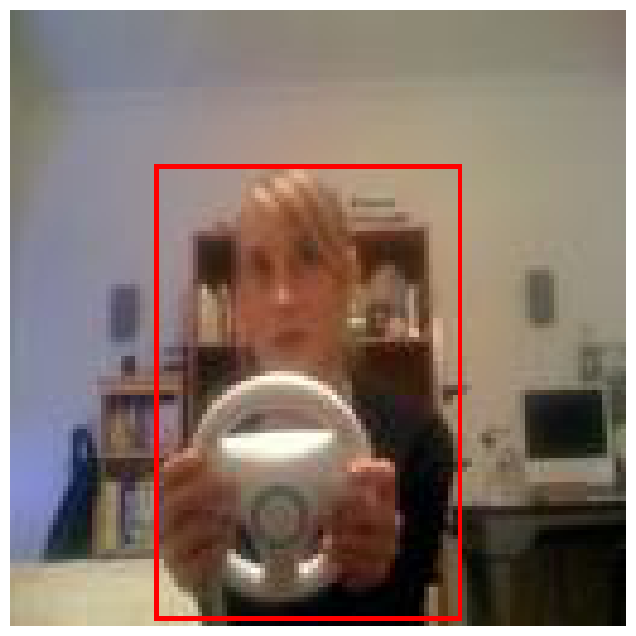

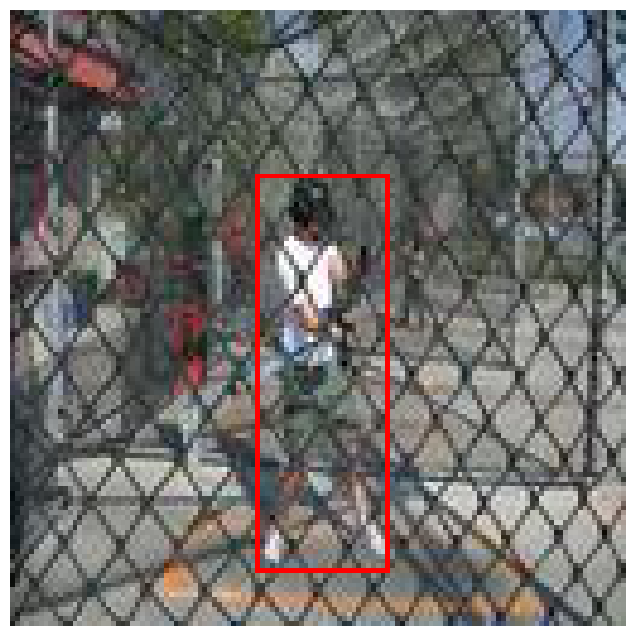

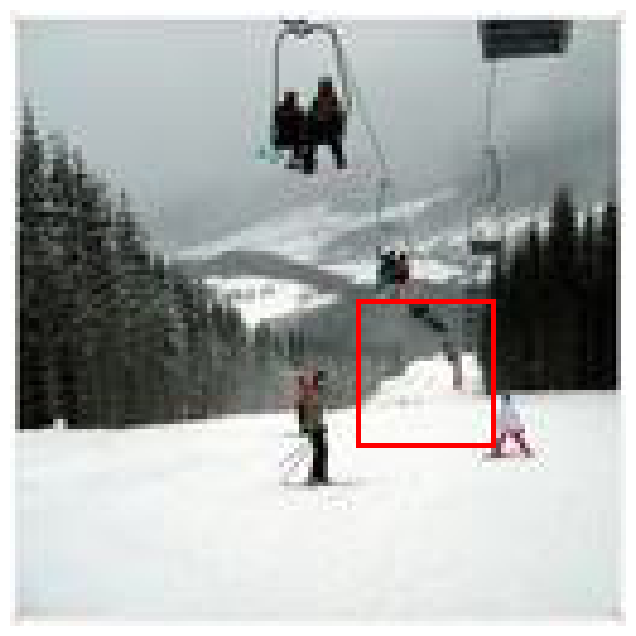

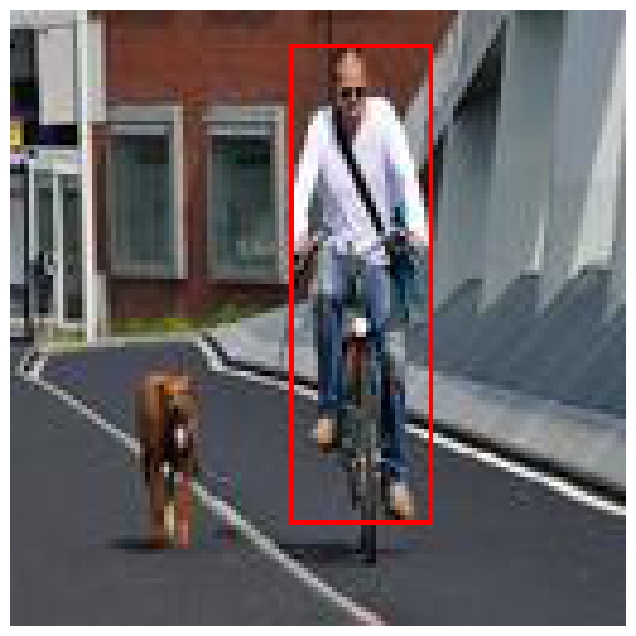

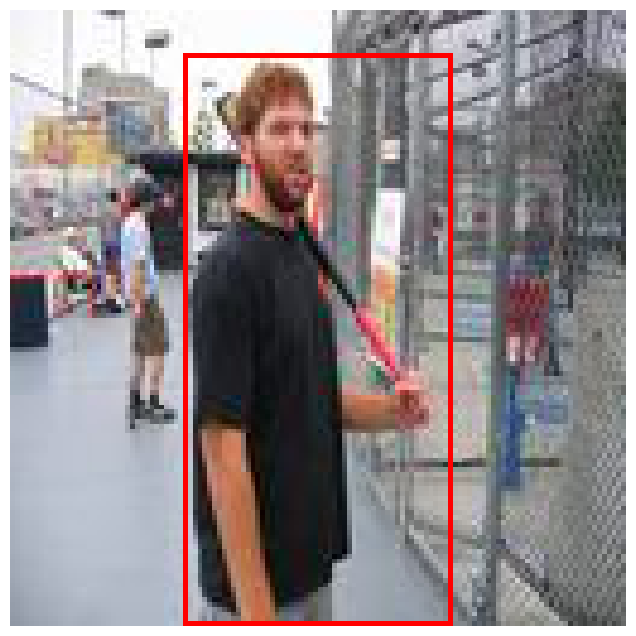

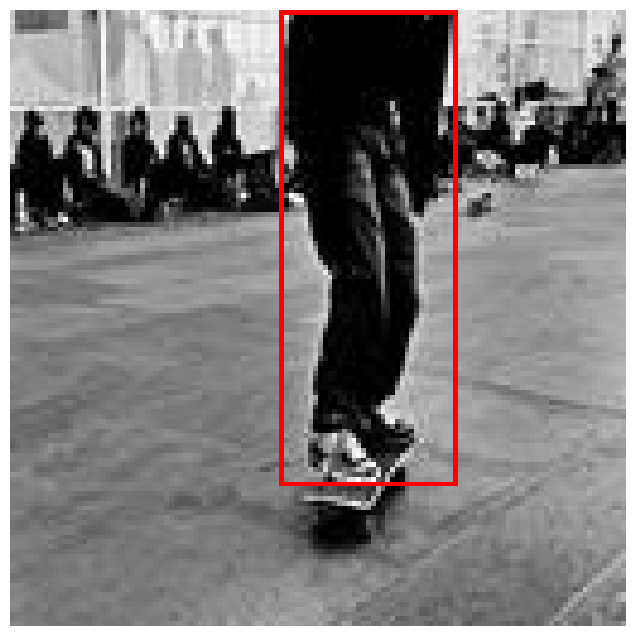

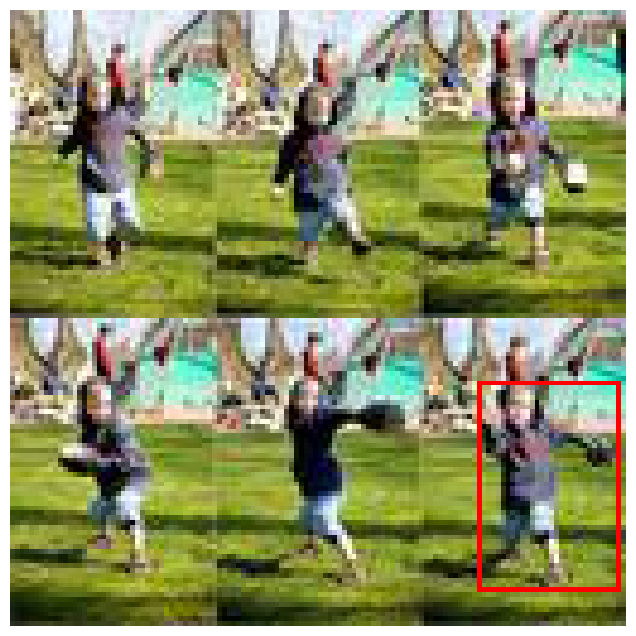

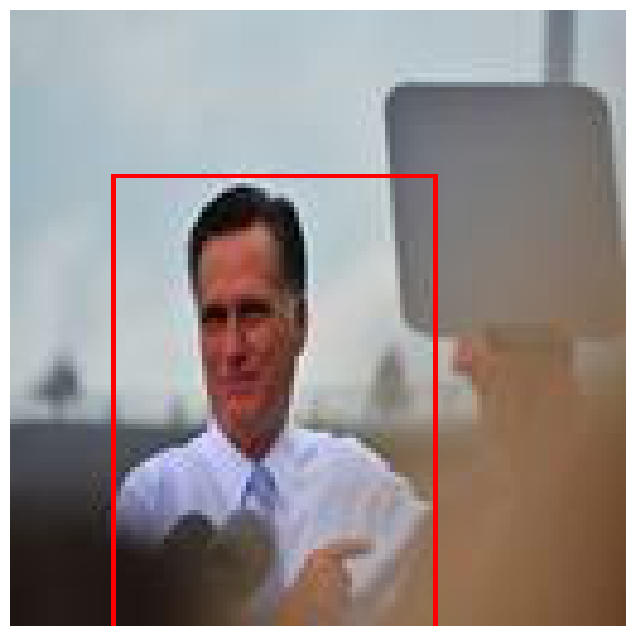

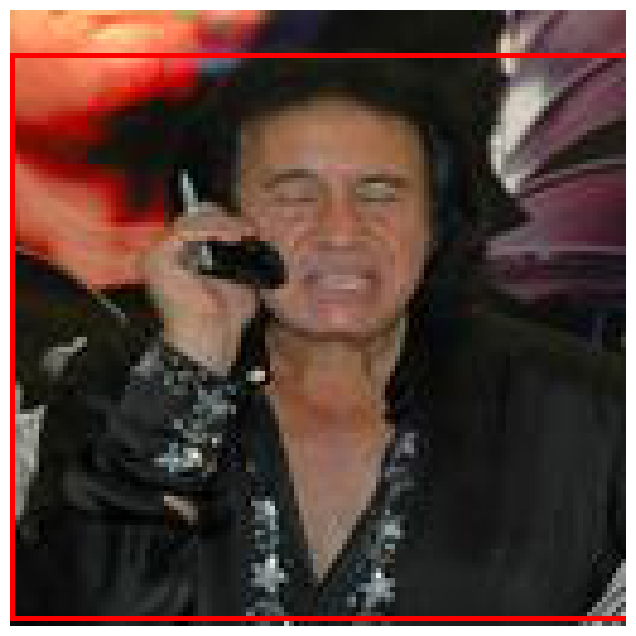

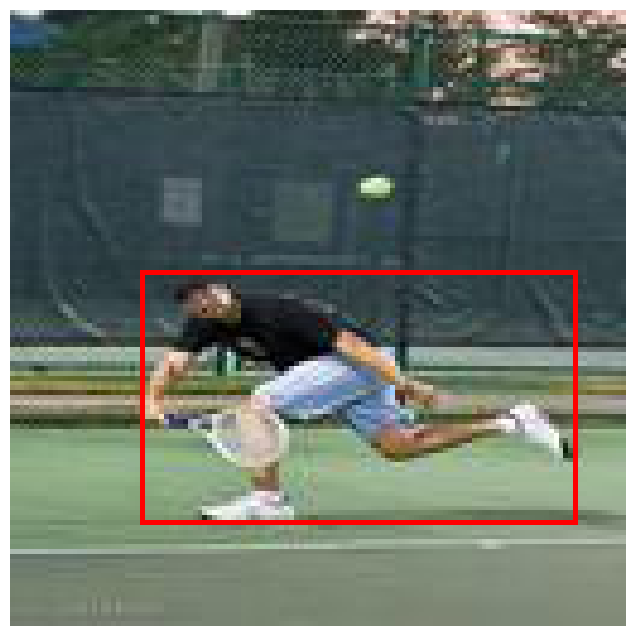

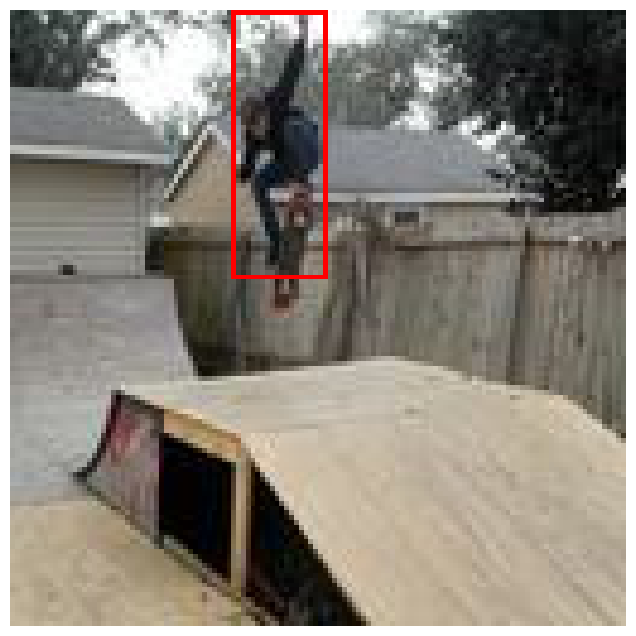

In [ ]:
json_path = paths["Preprocessed_Train_json"]
train_path = paths["Train_resized"]

with open(json_path, 'r') as f:
    coco_data = js.load(f)

    i=0

for img in coco_data:
    img_path = path.join(train_path, img["img_id"])
    if not path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    x, y, w, h = img["bbox"]
    cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    i+=1
    if i==100:
        break